In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import math

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# DATA LOADING AND PREPROCESSING

def load_data(file_path):
    """Load data from Excel or CSV file."""
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        else:
            df = pd.read_csv(file_path)
        return df
    except Exception as e:''
        print(f"Error loading file: {e}")
        return None

data_path = '/content/drive/MyDrive/PINNs/Suction_vsCP-modified_1.xlsx'
df = load_data(data_path)

In [ ]:
df.columns

Index(['Suction (kPa)', 'Silica fume (%)', 'Lime (%)', 'Gypsum content (%)',
       'Applied vertical stress (kPa)', 'Degree of Saturation (%)',
       'Collapse Potential (%)'],
      dtype='object')

In [ ]:
df['Silica fume (%)'].unique()

array([0, 2, 4, 6, 8])

In [ ]:
df['Lime (%)'].unique()

array([0, 2, 4, 6, 8])

In [ ]:
df['Gypsum content (%)'].unique()

array([15, 35, 60, 70])

In [ ]:
df['Applied vertical stress (kPa)'].unique()

array([200. ,  25. ,  50. ,  12.5])

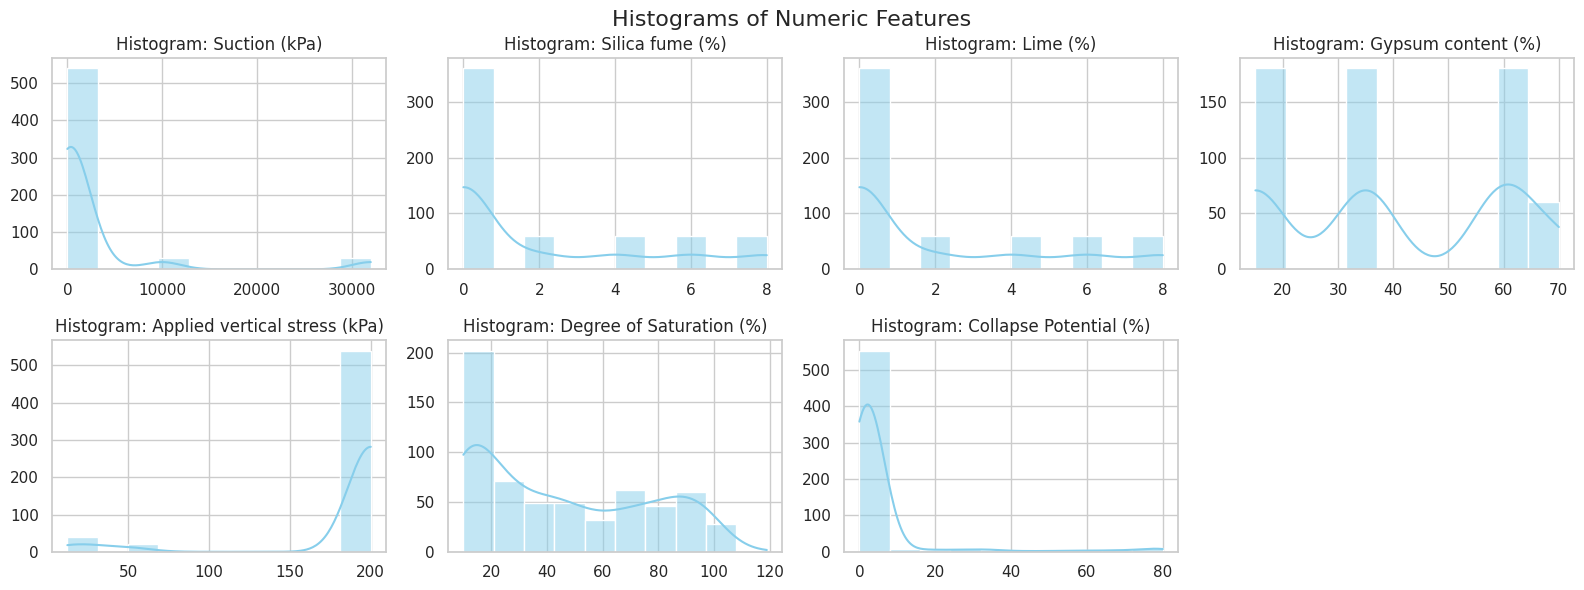

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# Select numeric columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
n = len(numeric_cols)

# Subplot grid size
cols = 4  # 4 per row
rows = math.ceil(n / cols)

# === HISTOGRAMS ===
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', bins=10)
    axes[i].set_title(f"Histogram: {col}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


    # Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

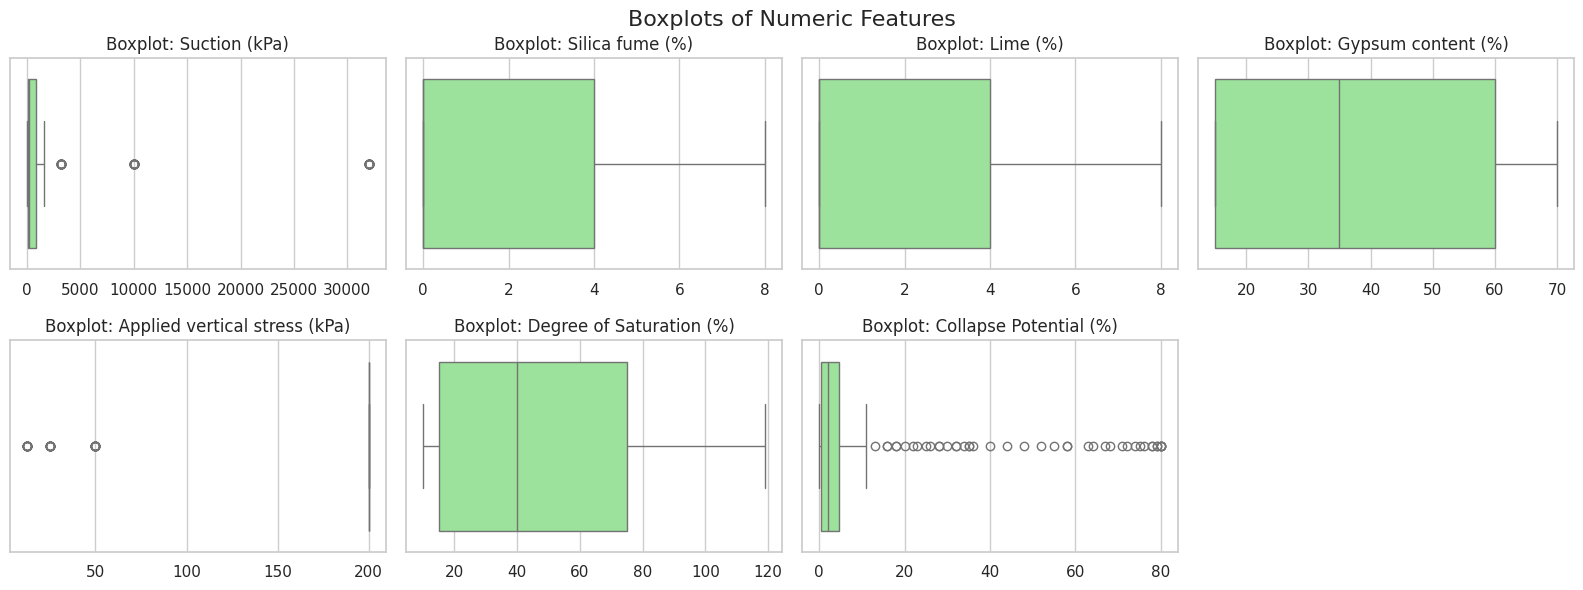

In [ ]:
# BOXPLOTS
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(f"Boxplot: {col}")
    axes[i].set_xlabel('')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplots of Numeric Features", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

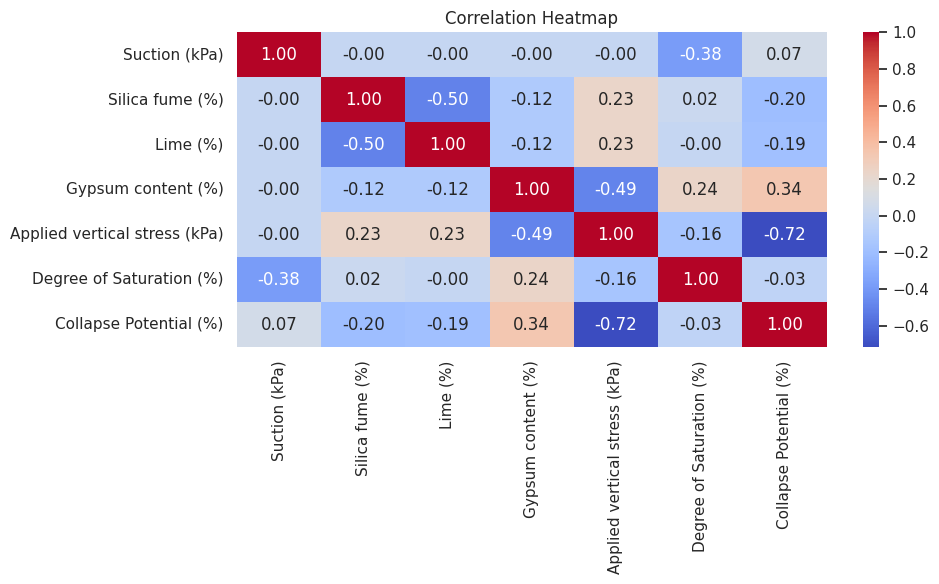

In [ ]:
# CORRELATION HEATMAP
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

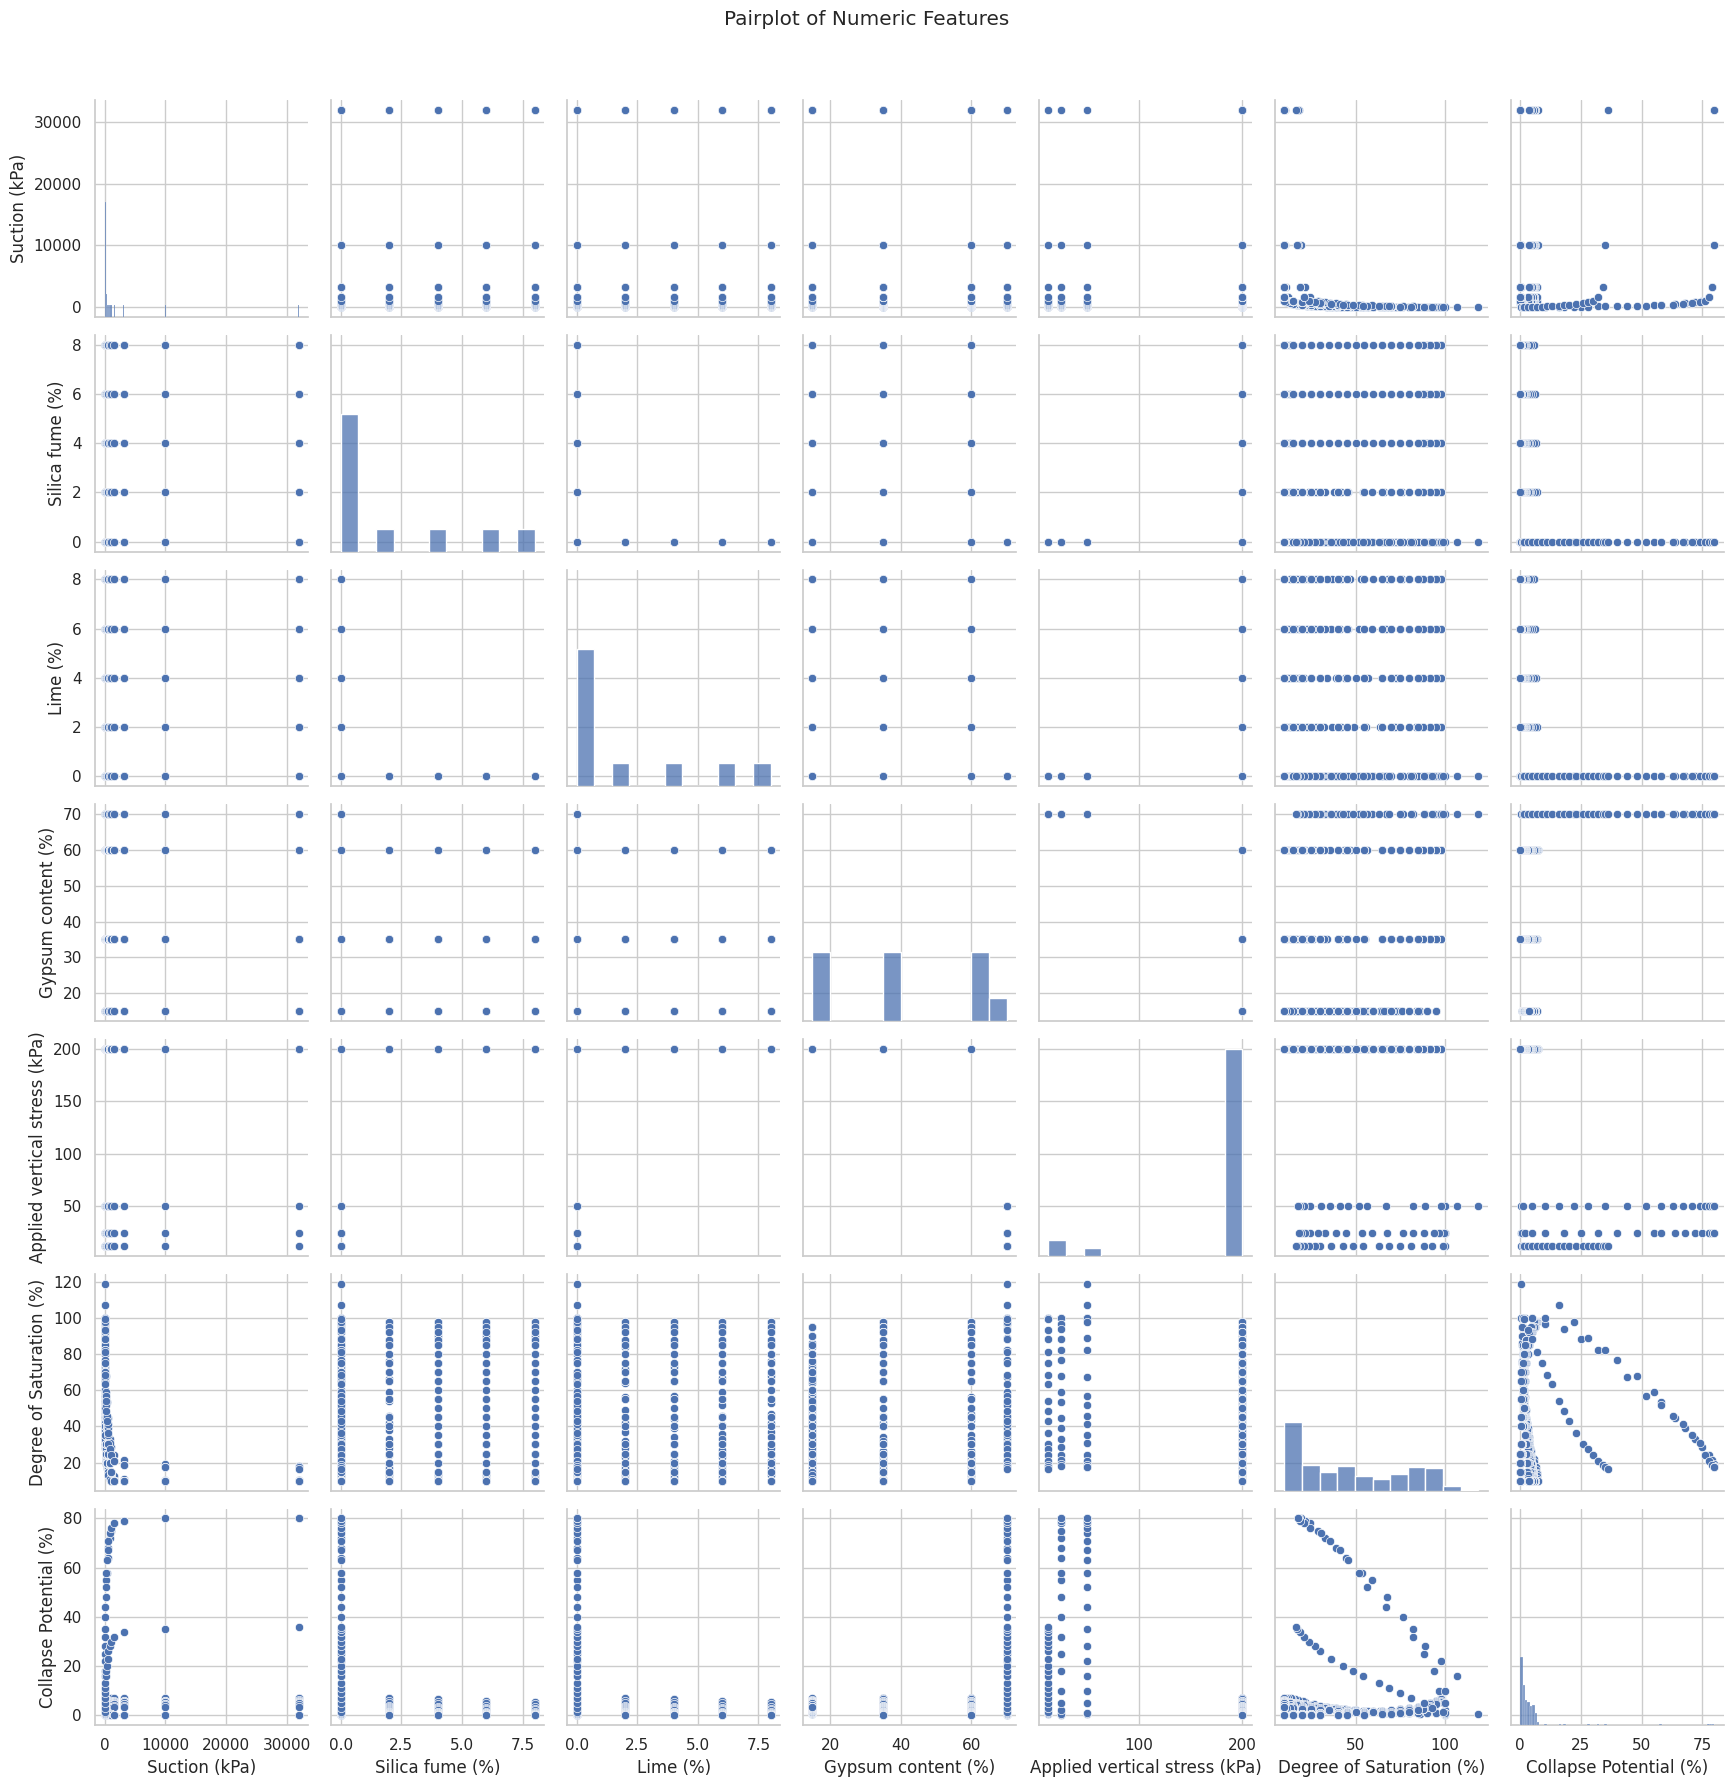

In [ ]:
# PAIRPLOT
if len(numeric_cols) <= 10:
    sns.pairplot(df[numeric_cols])
    plt.suptitle("Pairplot of Numeric Features", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Too many numeric features for pairplot; skipping.")

In [ ]:
if df is None:
    # Create synthetic data if real data isn't available
    print("Using synthetic data as fallback")
    def create_synthetic_data(n_samples=1000):
        np.random.seed(42)
        suction = np.random.uniform(0, 100, n_samples)
        silica  = np.random.uniform(0, 20, n_samples)
        lime    = np.random.uniform(0, 10, n_samples)
        gypsum  = np.random.uniform(0, 30, n_samples)
        stress  = np.random.uniform(50, 500, n_samples)
        saturation = np.random.uniform(30, 100, n_samples)

        # Simple relationship for synthetic data
        collapse = (0.1*suction + 0.05*silica - 0.2*lime + 0.15*gypsum +
                    0.002*stress - 0.01*saturation) / 10
        # Add noise
        collapse += np.random.normal(0, 0.5, n_samples)

        data = {
            'Suction (kPa)': suction,
            'Silica fume (%)': silica,
            'Lime (%)': lime,
            'Gypsum content (%)': gypsum,
            'Applied vertical stress (kPa)': stress,
            'Degree of Saturation (%)': saturation,
            'Collapse Potential (%)': collapse
        }
        return pd.DataFrame(data)

    df = create_synthetic_data()

In [ ]:
# Data preprocessing
print("\n=== Data Summary ===")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 samples:")
print(df.head())
print("\nDescriptive statistics:")
print(df.describe())


=== Data Summary ===
Dataset shape: (600, 7)

First 5 samples:
   Suction (kPa)  Silica fume (%)  Lime (%)  Gypsum content (%)  \
0              5                0         0                  15   
1             10                0         0                  15   
2             16                0         0                  15   
3             25                0         0                  15   
4             32                0         0                  15   

   Applied vertical stress (kPa)  Degree of Saturation (%)  \
0                          200.0                      50.0   
1                          200.0                      40.0   
2                          200.0                      42.8   
3                          200.0                      45.0   
4                          200.0                      53.5   

   Collapse Potential (%)  
0                    1.50  
1                    1.40  
2                    1.36  
3                    1.30  
4                   

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Remove rows with missing values if any
df = df.dropna()


Missing values per column:
Suction (kPa)                    0
Silica fume (%)                  0
Lime (%)                         0
Gypsum content (%)               0
Applied vertical stress (kPa)    0
Degree of Saturation (%)         0
Collapse Potential (%)           0
dtype: int64


# Enhancing PINNs with K-Fold, Visualizations, and Saving




In [ ]:
# Suppress Warnings and Logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
absl.logging.set_verbosity('error')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
import matplotlib.pyplot as plt
import copy
from datetime import datetime

In [ ]:
# Epoch Logger
class EpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, interval=100):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            print(f"Epoch {epoch + 1}: Loss = {logs['loss']:.4f}, Val Loss = {logs['val_loss']:.4f}")

In [ ]:
# Model Definition
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.d1 = tf.keras.layers.Dense(units, activation='tanh')
        self.d2 = tf.keras.layers.Dense(units, activation='tanh')
        # Added for MC dropout
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.projection = None

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if input_dim != self.units:
            self.projection = tf.keras.layers.Dense(self.units, activation='linear')
        super().build(input_shape)

    def call(self, x, training=None):
        shortcut = x
        if self.projection is not None:
            shortcut = self.projection(x)
        x = self.d1(x)
        # MC dropout
        x = self.dropout(x, training=training)
        x = self.d2(x)
        return x + shortcut

In [ ]:
class CollapsePINN(tf.keras.Model):
    def __init__(self, input_dim=6, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = tf.keras.layers.Dense(128, activation='tanh')
        # Added for MC dropout
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.res_block1 = ResidualBlock(128)
        self.res_block2 = ResidualBlock(64)
        self.output_layer = tf.keras.layers.Dense(1)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.input_dim = input_dim

    def call(self, inputs, training=None):
        x = self.dense1(inputs)
        # MC dropout
        x = self.dropout1(x, training=training)
        x = self.res_block1(x, training=training)
        x = self.res_block2(x, training=training)
        return self.output_layer(x)

In [ ]:
# Uncertainty Analysis Functions
def monte_carlo_dropout_predict(model, X, n_samples=100):
    """Perform MC dropout predictions for uncertainty estimation"""
    predictions = []
    for _ in range(n_samples):
        # Keep dropout active
        pred = model(X, training=True)
        predictions.append(pred)
    return tf.stack(predictions, axis=0)

In [ ]:
def plot_prediction_uncertainty(model, X, y, scaler_X, scaler_y, feature_names, model_dir):
    """Plot prediction uncertainty vs input variables"""
    # Convert to original scale for interpretation
    X_orig = scaler_X.inverse_transform(X)
    y_orig = scaler_y.inverse_transform(y)

    # Get MC dropout predictions
    mc_preds = monte_carlo_dropout_predict(model, X)
    mc_preds_orig = scaler_y.inverse_transform(mc_preds.numpy().reshape(-1, 1))
    mc_preds_orig = mc_preds_orig.reshape(-1, len(X))

    # Calculate statistics
    mean_pred = np.mean(mc_preds_orig, axis=0)
    std_pred = np.std(mc_preds_orig, axis=0)

    # Plot for each feature
    plt.figure(figsize=(15, 20))
    for i, feature in enumerate(feature_names):
        plt.subplot(3, 2, i+1)
        # Sort by feature value for clean plotting
        sort_idx = np.argsort(X_orig[:, i])
        x_sorted = X_orig[sort_idx, i]
        mean_sorted = mean_pred[sort_idx]
        std_sorted = std_pred[sort_idx]
        y_sorted = y_orig[sort_idx]

        plt.plot(x_sorted, mean_sorted, 'b-', label='Mean prediction')
        plt.fill_between(x_sorted,
                        mean_sorted - 2*std_sorted,
                        mean_sorted + 2*std_sorted,
                        alpha=0.2, color='b', label='±2σ uncertainty')
        plt.scatter(x_sorted, y_sorted, c='r', s=5, alpha=0.3, label='True values')

        plt.xlabel(feature)
        plt.ylabel('Collapse Potential (%)')
        plt.title(f'Prediction Uncertainty vs {feature}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    uncertainty_plot_path = os.path.join(model_dir, 'prediction_uncertainty.png')
    plt.savefig(uncertainty_plot_path)
    plt.show()

    return mean_pred, std_pred, uncertainty_plot_path

In [ ]:
def analyze_parameter_uncertainty(model, X_sample, n_samples=100):
    """Analyze impact of weight uncertainty on predictions"""
    # Get trainable variables
    variables = model.trainable_variables

    # Store original weights
    original_weights = [v.numpy() for v in variables]

    # Generate perturbed predictions
    predictions = []
    for _ in range(n_samples):
        # Add small Gaussian noise to weights
        for v, orig in zip(variables, original_weights):
            noise = tf.random.normal(shape=v.shape, mean=0.0, stddev=0.01)
            v.assign(orig + noise)

        # Predict with perturbed weights
        pred = model(X_sample, training=False)
        predictions.append(pred.numpy())

    # Restore original weights
    for v, orig in zip(variables, original_weights):
        v.assign(orig)

    # Calculate statistics
    predictions = np.array(predictions)
    mean_pred   = np.mean(predictions, axis=0)
    std_pred    = np.std(predictions, axis=0)

    return mean_pred, std_pred

In [ ]:
# Enhanced Model Saving
def save_model_with_requirements(model, model_path, X_sample, scaler_X, scaler_y, features, target, performance, model_dir):
    """Save model with all necessary components for deployment"""
    # Create package directory
    package_dir = os.path.join(model_dir, 'deployment_package')
    os.makedirs(package_dir, exist_ok=True)

    # Save model
    model_save_path = os.path.join(package_dir, 'model.keras')
    model.save(model_save_path)

    # Save scalers
    joblib.dump(scaler_X, os.path.join(package_dir, 'scaler_X.joblib'))
    joblib.dump(scaler_y, os.path.join(package_dir, 'scaler_y.joblib'))

    # Save metadata
    metadata = {
        'features': features,
        'target': target,
        'input_dim': X_sample.shape[1],
        'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'performance': performance
    }
    joblib.dump(metadata, os.path.join(package_dir, 'metadata.joblib'))

    # Generate requirements.txt
    requirements = [
        f"tensorflow=={tf.__version__}",
        f"numpy=={np.__version__}",
        f"pandas=={pd.__version__}",
        f"scikit-learn=={joblib.__version__.split('+')[0]}",
        "matplotlib",
        "joblib"
    ]

    with open(os.path.join(package_dir, 'requirements.txt'), 'w') as f:
        f.write('\n'.join(requirements))

    print(f"\nModel package saved to: {package_dir}")
    return package_dir

In [ ]:
# Local Deployment Options
def create_gui(package_dir):
    """Create a simple GUI for model interaction"""
    try:
        import tkinter as tk
        from tkinter import ttk
    except ImportError:
        print("Tkinter not available. Skipping GUI creation.")
        return

    # Load model components
    custom_objects = {'ResidualBlock': ResidualBlock, 'CollapsePINN': CollapsePINN}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(os.path.join(package_dir, 'model.keras'))

    scaler_X = joblib.load(os.path.join(package_dir, 'scaler_X.joblib'))
    scaler_y = joblib.load(os.path.join(package_dir, 'scaler_y.joblib'))
    metadata = joblib.load(os.path.join(package_dir, 'metadata.joblib'))

    # Create GUI
    root = tk.Tk()
    root.title("Collapse Potential Predictor")

    # Input fields
    inputs = {}
    for i, feature in enumerate(metadata['features']):
        tk.Label(root, text=feature).grid(row=i, column=0, padx=5, pady=5)
        inputs[feature] = tk.Entry(root)
        inputs[feature].grid(row=i, column=1, padx=5, pady=5)

    # Prediction button
    def predict():
        try:
            # Get input values
            input_values = []
            for feature in metadata['features']:
                value = float(inputs[feature].get())
                input_values.append(value)

            # Scale and predict
            scaled_input = scaler_X.transform([input_values])
            scaled_pred = model.predict(scaled_input)
            prediction = scaler_y.inverse_transform(scaled_pred)[0][0]

            # Show result
            result_label.config(text=f"Predicted Collapse Potential: {prediction:.2f}%")
        except Exception as e:
            result_label.config(text=f"Error: {str(e)}")

    predict_btn = tk.Button(root, text="Predict", command=predict)
    predict_btn.grid(row=len(metadata['features']), columnspan=2, pady=10)

    # Result display
    result_label = tk.Label(root, text="")
    result_label.grid(row=len(metadata['features'])+1, columnspan=2)

    # Save GUI code
    gui_code = f"""import tkinter as tk
import joblib
import tensorflow as tf
import numpy as np
from {__name__} import ResidualBlock, CollapsePINN

# Load model components
package_dir = r"{os.path.abspath(package_dir)}"
custom_objects = {{'ResidualBlock': ResidualBlock, 'CollapsePINN': CollapsePINN}}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(os.path.join(package_dir, 'model.keras'))

scaler_X = joblib.load(os.path.join(package_dir, 'scaler_X.joblib'))
scaler_y = joblib.load(os.path.join(package_dir, 'scaler_y.joblib'))
metadata = joblib.load(os.path.join(package_dir, 'metadata.joblib'))

# Create GUI
root = tk.Tk()
root.title("Collapse Potential Predictor")

# Input fields
inputs = {{}}
for i, feature in enumerate(metadata['features']):
    tk.Label(root, text=feature).grid(row=i, column=0, padx=5, pady=5)
    inputs[feature] = tk.Entry(root)
    inputs[feature].grid(row=i, column=1, padx=5, pady=5)

# Prediction function
def predict():
    try:
        input_values = []
        for feature in metadata['features']:
            value = float(inputs[feature].get())
            input_values.append(value)

        scaled_input = scaler_X.transform([input_values])
        scaled_pred = model.predict(scaled_input)
        prediction = scaler_y.inverse_transform(scaled_pred)[0][0]
        result_label.config(text=f"Predicted Collapse Potential: {{prediction:.2f}}%")
    except Exception as e:
        result_label.config(text=f"Error: {{str(e)}}")

predict_btn = tk.Button(root, text="Predict", command=predict)
predict_btn.grid(row=len(metadata['features']), columnspan=2, pady=10)

result_label = tk.Label(root, text="")
result_label.grid(row=len(metadata['features'])+1, columnspan=2)

root.mainloop()
"""

    gui_code_path = os.path.join(package_dir, 'gui_interface.py')
    with open(gui_code_path, 'w') as f:
        f.write(gui_code)

    print(f"GUI code saved to: {gui_code_path}")
    root.mainloop()

In [ ]:
def create_spreadsheet_interface(package_dir):
    """Generate code for spreadsheet integration"""
    code = f"""# Spreadsheet Integration Code for Collapse Potential Predictor
import os
import joblib
import tensorflow as tf
import numpy as np
from {__name__} import ResidualBlock, CollapsePINN

# Load model components
package_dir = r"{os.path.abspath(package_dir)}"
custom_objects = {{'ResidualBlock': ResidualBlock, 'CollapsePINN': CollapsePINN}}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(os.path.join(package_dir, 'model.keras'))

scaler_X = joblib.load(os.path.join(package_dir, 'scaler_X.joblib'))
scaler_y = joblib.load(os.path.join(package_dir, 'scaler_y.joblib'))

def predict_collapse(suction, silica, lime, gypsum, stress, saturation):
    \"\"\"Predict collapse potential from input parameters\"\"\"
    inputs = np.array([[suction, silica, lime, gypsum, stress, saturation]])
    scaled_inputs = scaler_X.transform(inputs)
    scaled_pred = model.predict(scaled_inputs)
    return float(scaler_y.inverse_transform(scaled_pred)[0][0])

# Example usage:
# prediction = predict_collapse(50, 10, 2, 15, 200, 80)
# print(f"Predicted Collapse Potential: {{prediction:.2f}}%")
"""

    spreadsheet_path = os.path.join(package_dir, 'spreadsheet_integration.py')
    with open(spreadsheet_path, 'w') as f:
        f.write(code)

    print(f"Spreadsheet integration code saved to: {spreadsheet_path}")
    return spreadsheet_path

In [ ]:
# Evaluation Function
def evaluate_model(model, X, y, scaler_y):
    y_pred_scaled = model.predict(X)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

In [ ]:
# Load Data
data_path = '/content/drive/MyDrive/PINNs/Suction_vsCP-modified_1.xlsx'
def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except:
        return None

In [ ]:
df = load_data(data_path)
if df is None:
    print("Synthetic fallback data used.")
    def create_synthetic_data(n=1000):
        suction = np.random.uniform(0, 100, n)
        silica = np.random.uniform(0, 20, n)
        lime = np.random.uniform(0, 10, n)
        gypsum = np.random.uniform(0, 30, n)
        stress = np.random.uniform(50, 500, n)
        saturation = np.random.uniform(30, 100, n)
        collapse = (0.1*suction + 0.05*silica - 0.2*lime + 0.15*gypsum +
                    0.002*stress - 0.01*saturation) / 10
        collapse += np.random.normal(0, 0.5, n)
        return pd.DataFrame({
            'Suction (kPa)': suction,
            'Silica fume (%)': silica,
            'Lime (%)': lime,
            'Gypsum content (%)': gypsum,
            'Applied vertical stress (kPa)': stress,
            'Degree of Saturation (%)': saturation,
            'Collapse Potential (%)': collapse
        })
    df = create_synthetic_data()

features = ['Suction (kPa)', 'Silica fume (%)', 'Lime (%)',
            'Gypsum content (%)', 'Applied vertical stress (kPa)',
            'Degree of Saturation (%)']
target = 'Collapse Potential (%)'

X = df[features].values
y = df[target].values.reshape(-1, 1)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [ ]:
# Training
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model_dir = "/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC"
os.makedirs(model_dir, exist_ok=True)

fold_results = []
best_rmse = float('inf')
best_model_path = ""
best_fold = -1

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    print(f"\n=== Fold {fold + 1}/{n_splits} ===")
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_val_tensor   = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val_tensor   = tf.convert_to_tensor(y_val, dtype=tf.float32)

    model = CollapsePINN(input_dim=X_train.shape[1])
    model.compile(optimizer=model.optimizer, loss='mse')

    checkpoint_path = os.path.join(model_dir, f"best_model_fold{fold+1}.keras")
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)

    history = model.fit(
        X_train_tensor, y_train_tensor,
        validation_data=(X_val_tensor, y_val_tensor),
        epochs=1000,
        batch_size=32,
        callbacks=[checkpoint, EpochLogger(interval=100)],
        verbose=0
    )

    val_rmse, val_r2 = evaluate_model(model, X_val_tensor, y_val_tensor, scaler_y)
    print(f"Fold {fold+1}: RMSE={val_rmse:.4f}, R²={val_r2:.4f}")

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_path = checkpoint_path
        best_fold = fold + 1

    fold_results.append({
        'fold': fold + 1,
        'model_path': checkpoint_path,
        'rmse': val_rmse,
        'r2': val_r2,
        'history': history.history
    })


=== Fold 1/4 ===
Epoch 100: Loss = 0.0956, Val Loss = 0.2626
Epoch 200: Loss = 0.1128, Val Loss = 0.2596
Epoch 300: Loss = 0.0356, Val Loss = 0.0798
Epoch 400: Loss = 0.0284, Val Loss = 0.0414
Epoch 500: Loss = 0.0230, Val Loss = 0.0427
Epoch 600: Loss = 0.0182, Val Loss = 0.0816
Epoch 700: Loss = 0.0081, Val Loss = 0.0790
Epoch 800: Loss = 0.0104, Val Loss = 0.0781
Epoch 900: Loss = 0.0111, Val Loss = 0.0513
Epoch 1000: Loss = 0.0059, Val Loss = 0.0395
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Fold 1: RMSE=2.7201, R²=0.9668

=== Fold 2/4 ===
Epoch 100: Loss = 0.1099, Val Loss = 0.1661
Epoch 200: Loss = 0.1345, Val Loss = 0.1434
Epoch 300: Loss = 0.0293, Val Loss = 0.0787
Epoch 400: Loss = 0.0172, Val Loss = 0.0648
Epoch 500: Loss = 0.0152, Val Loss = 0.0498
Epoch 600: Loss = 0.0096, Val Loss = 0.0625
Epoch 700: Loss = 0.0113, Val Loss = 0.0355
Epoch 800: Loss = 0.0135, Val Loss = 0.0901
Epoch 900: Loss = 0.0133, Val Loss = 0.0511
Epoch 1000: Loss = 0.0236, Val Loss = 0.0574
5/5 ━━━━━━━━━

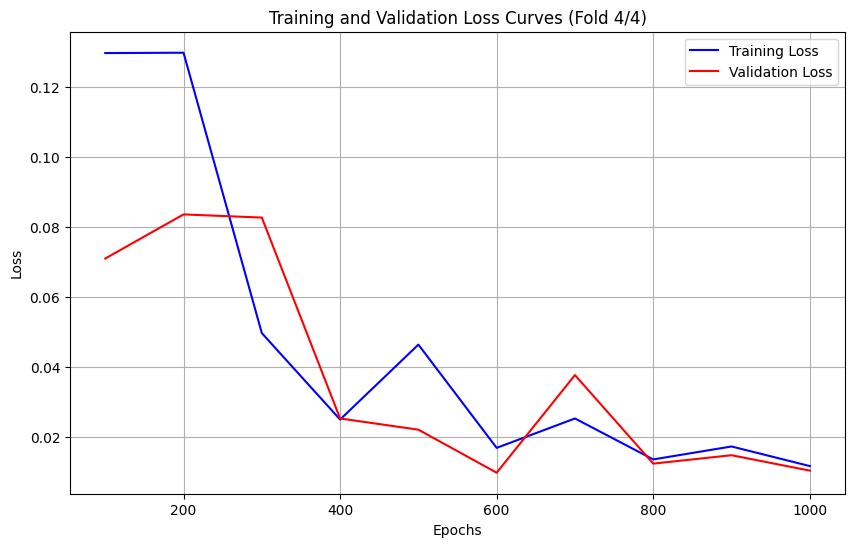

In [ ]:
# Manully draw train and val loss
import matplotlib.pyplot as plt

epochs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
train_loss = [0.1298, 0.1299, 0.0498, 0.0251, 0.0465, 0.0170, 0.0254, 0.0137, 0.0174, 0.0118]
val_loss = [0.0711, 0.0837, 0.0828, 0.0254, 0.0222, 0.0099, 0.0378, 0.0125, 0.0149, 0.0105]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss Curves (Fold 4/4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



```
Key observations from the curves:

Both training and validation losses generally decrease over time

The model achieves its best validation loss around epoch 600 (0.0099)

There's some fluctuation in later epochs, suggesting possible overfitting or need for learning rate adjustment

The final validation loss (0.0105 at epoch 1000) is very close to the training loss (0.0118), indicating good generalization

The excellent R² score of 0.9828 and RMSE of 1.4047 in the final fold suggest the model is performing very well on this task.


```



In [ ]:
print("\n=== Cross-Validation Results ===")
for result in fold_results:
    print(f"Fold {result['fold']}: RMSE={result['rmse']:.4f}, R²={result['r2']:.4f}")
print(f"\nBest Model: Fold {best_fold}, RMSE={best_rmse:.4f}\nSaved to: {best_model_path}")


=== Cross-Validation Results ===
Fold 1: RMSE=2.7201, R²=0.9668
Fold 2: RMSE=3.2762, R²=0.9587
Fold 3: RMSE=2.7391, R²=0.9487
Fold 4: RMSE=1.4047, R²=0.9828

Best Model: Fold 4, RMSE=1.4047
Saved to: /content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/best_model_fold4.keras


In [ ]:
# Plot RMSE and R^2 for each fold
fold_nums = [result['fold'] for result in fold_results]
rmse_vals = [result['rmse'] for result in fold_results]
r2_vals = [result['r2'] for result in fold_results]

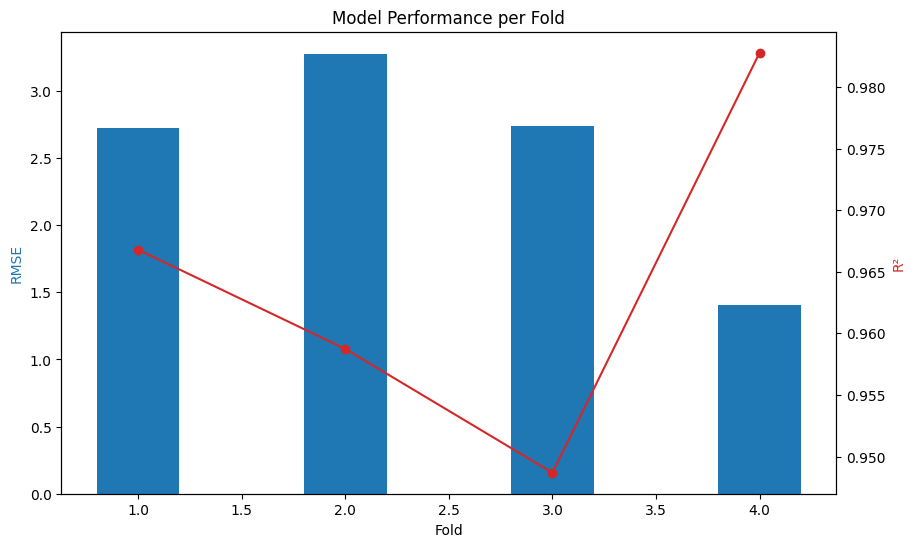

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.bar(fold_nums, rmse_vals, width=0.4, label='RMSE', color='tab:blue', align='center')
ax2.plot(fold_nums, r2_vals, label='R²', color='tab:red', marker='o')

ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE', color='tab:blue')
ax2.set_ylabel('R²', color='tab:red')

ax1.set_title('Model Performance per Fold')
ax1.grid(False)
plt.savefig(os.path.join(model_dir, 'fold_performance.png'))
plt.show()

In [ ]:
# Load Best Model
custom_objects = {'ResidualBlock': ResidualBlock, 'CollapsePINN': CollapsePINN}
with tf.keras.utils.custom_object_scope(custom_objects):
    best_model = tf.keras.models.load_model(best_model_path, compile=False)

all_rmse, all_r2 = evaluate_model(best_model, X_scaled, y_scaled, scaler_y)
print(f"\nBest Fold: {best_fold} - Overall RMSE: {all_rmse:.4f}, R²: {all_r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Best Fold: 4 - Overall RMSE: 1.1601, R²: 0.9928


In [ ]:
# Feature Importance
def compute_feature_importance(model, X_sample, features):
    X_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
    gradients = tape.gradient(predictions, X_tensor).numpy()
    importance = np.mean(np.abs(gradients), axis=0)
    importance = importance / importance.sum()
    return importance


=== Feature Importance ===
Suction (kPa): 0.0221
Lime (%): 0.1636
Gypsum content (%): 0.1689
Silica fume (%): 0.2014
Degree of Saturation (%): 0.2084
Applied vertical stress (kPa): 0.2356
Most important: Applied vertical stress (kPa)


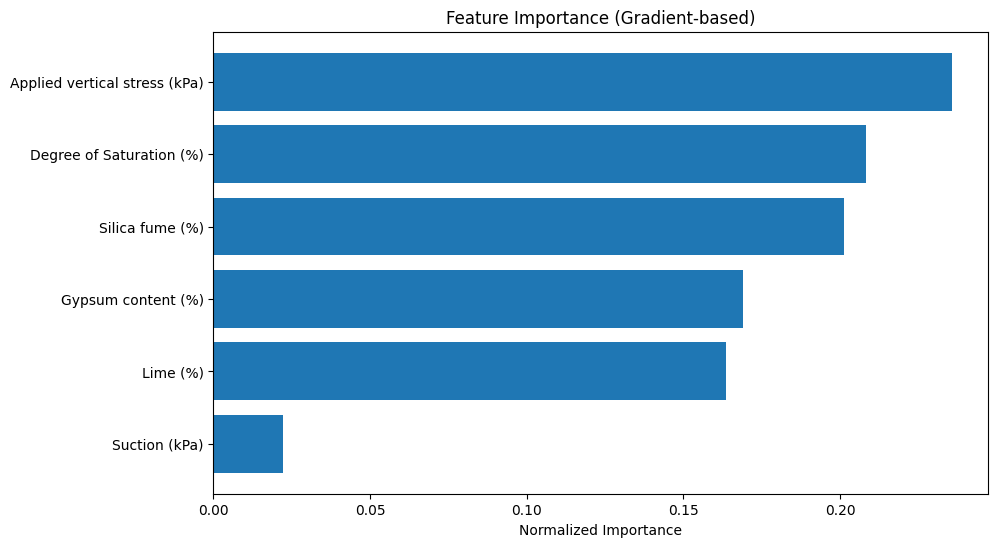

In [ ]:
importance = compute_feature_importance(best_model, X_scaled[:500], features)
sorted_idx = np.argsort(importance)
print("\n=== Feature Importance ===")
for i in sorted_idx:
    print(f"{features[i]}: {importance[i]:.4f}")
print(f"Most important: {features[np.argmax(importance)]}")

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], importance[sorted_idx])
plt.title('Feature Importance (Gradient-based)')
plt.xlabel('Normalized Importance')
plt.grid(False)
plt.savefig(os.path.join(model_dir, 'feature_importance.png'))
plt.show()

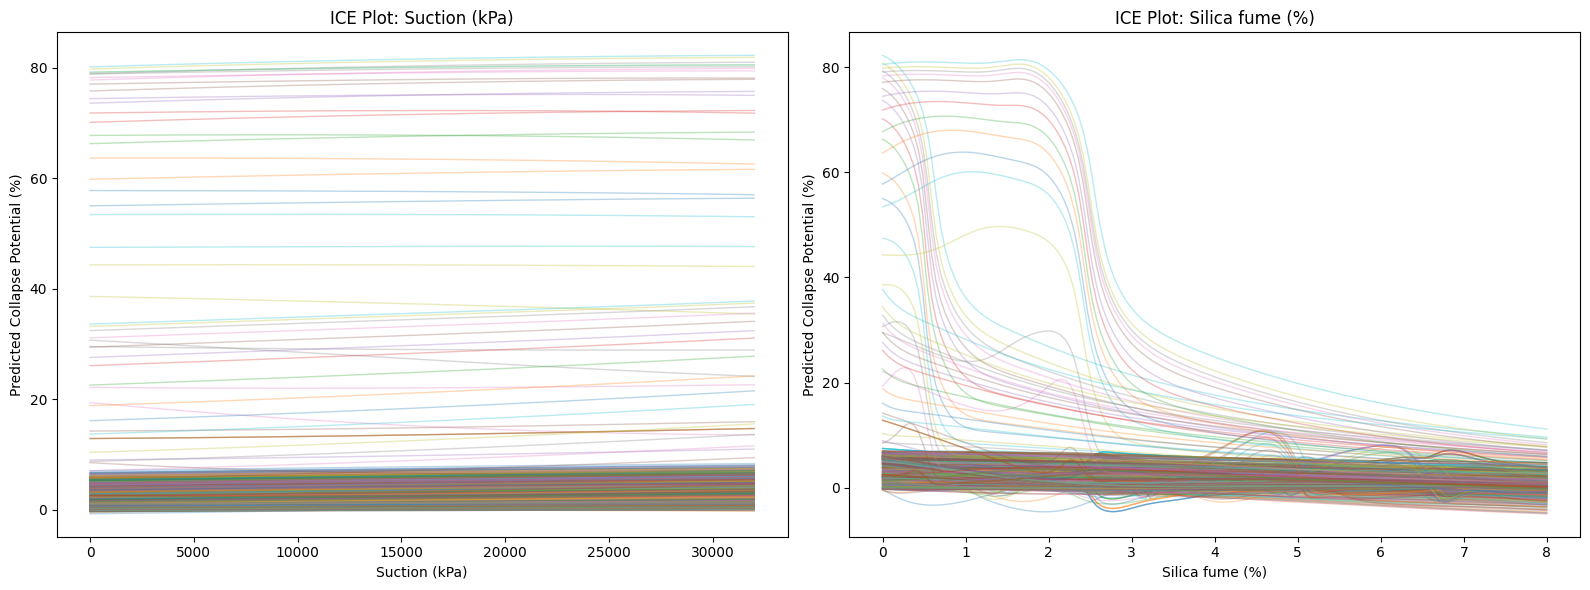

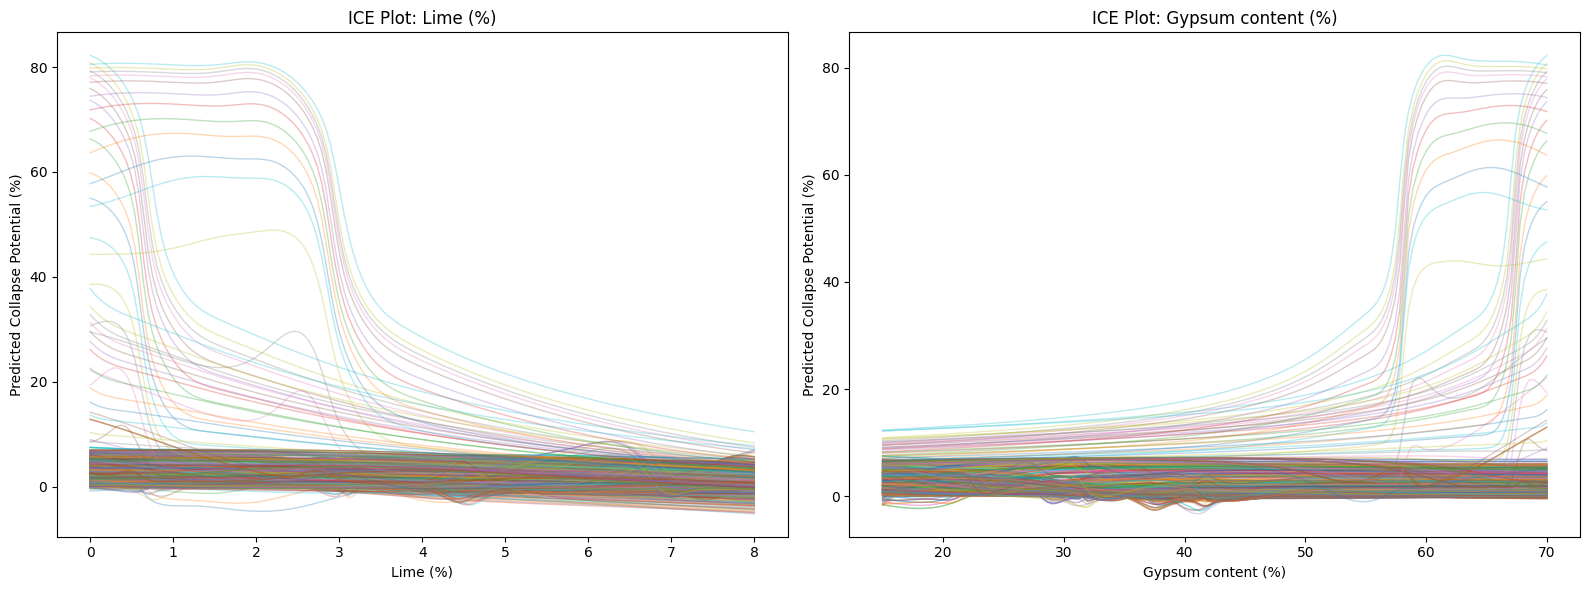

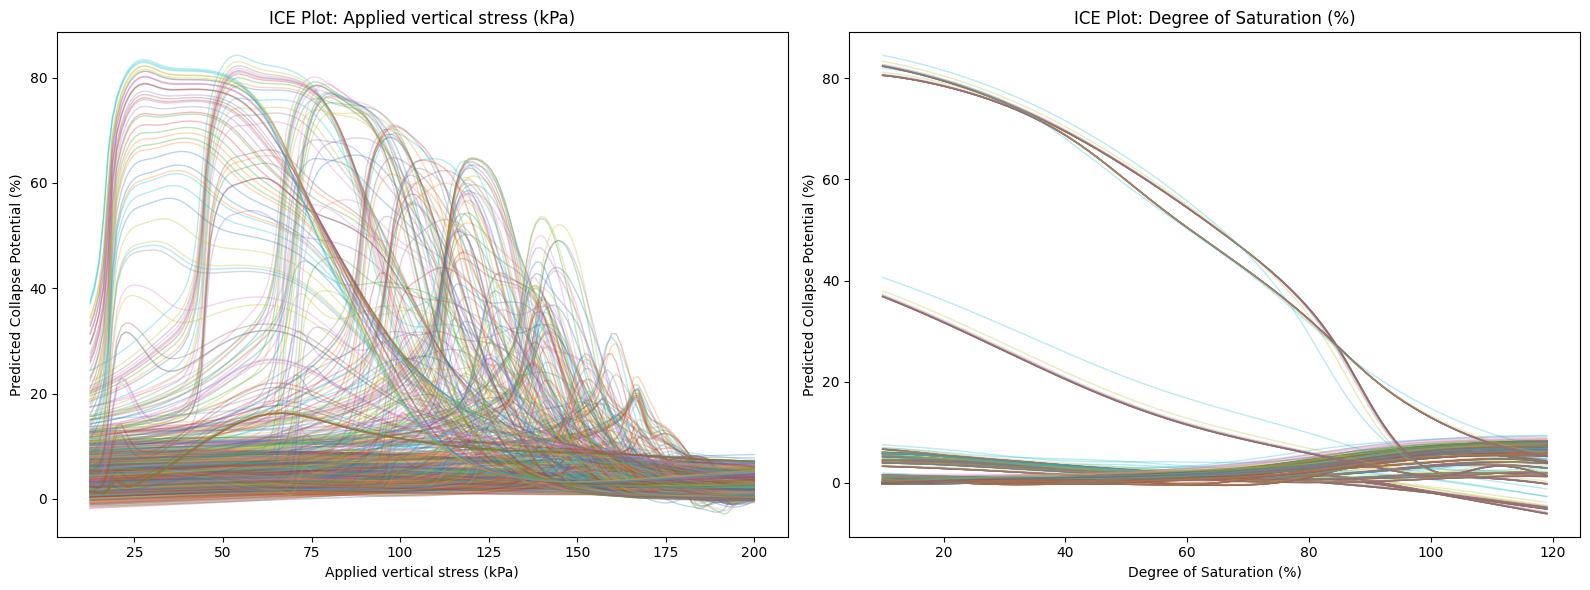

In [ ]:
# ICE Analysis
def plot_ice(model, X_sample, scaler_X, scaler_y, feature_names, model_dir):
    X_sample_orig = scaler_X.inverse_transform(X_sample)
    num_features = len(feature_names)

    for i in range(0, num_features, 2):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        for j in range(2):
            feature_idx = i + j
            if feature_idx >= num_features:
                axes[j].axis('off')
                continue

            feature_name = feature_names[feature_idx]
            values_to_plot = np.linspace(X_sample_orig[:, feature_idx].min(),
                                         X_sample_orig[:, feature_idx].max(), 150)

            for row in X_sample_orig:
                preds = []
                for val in values_to_plot:
                    modified = copy.deepcopy(row)
                    modified[feature_idx] = val
                    modified_scaled = scaler_X.transform(modified.reshape(1, -1))
                    input_tensor = tf.convert_to_tensor(modified_scaled, dtype=tf.float32)
                    pred_scaled = model(input_tensor, training=False).numpy()
                    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
                    preds.append(pred)

                axes[j].plot(values_to_plot, preds, alpha=0.3, linewidth=1)

            axes[j].set_title(f"ICE Plot: {feature_name}")
            axes[j].set_xlabel(feature_name)
            axes[j].set_ylabel("Predicted Collapse Potential (%)")
            axes[j].grid(False)

        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, f'ice_plot_{i//2}.png'))
        plt.show()

# Run ICE plots
plot_ice(best_model, X_scaled[:150], scaler_X, scaler_y, features, model_dir) #50


=== Running Uncertainty Analysis ===


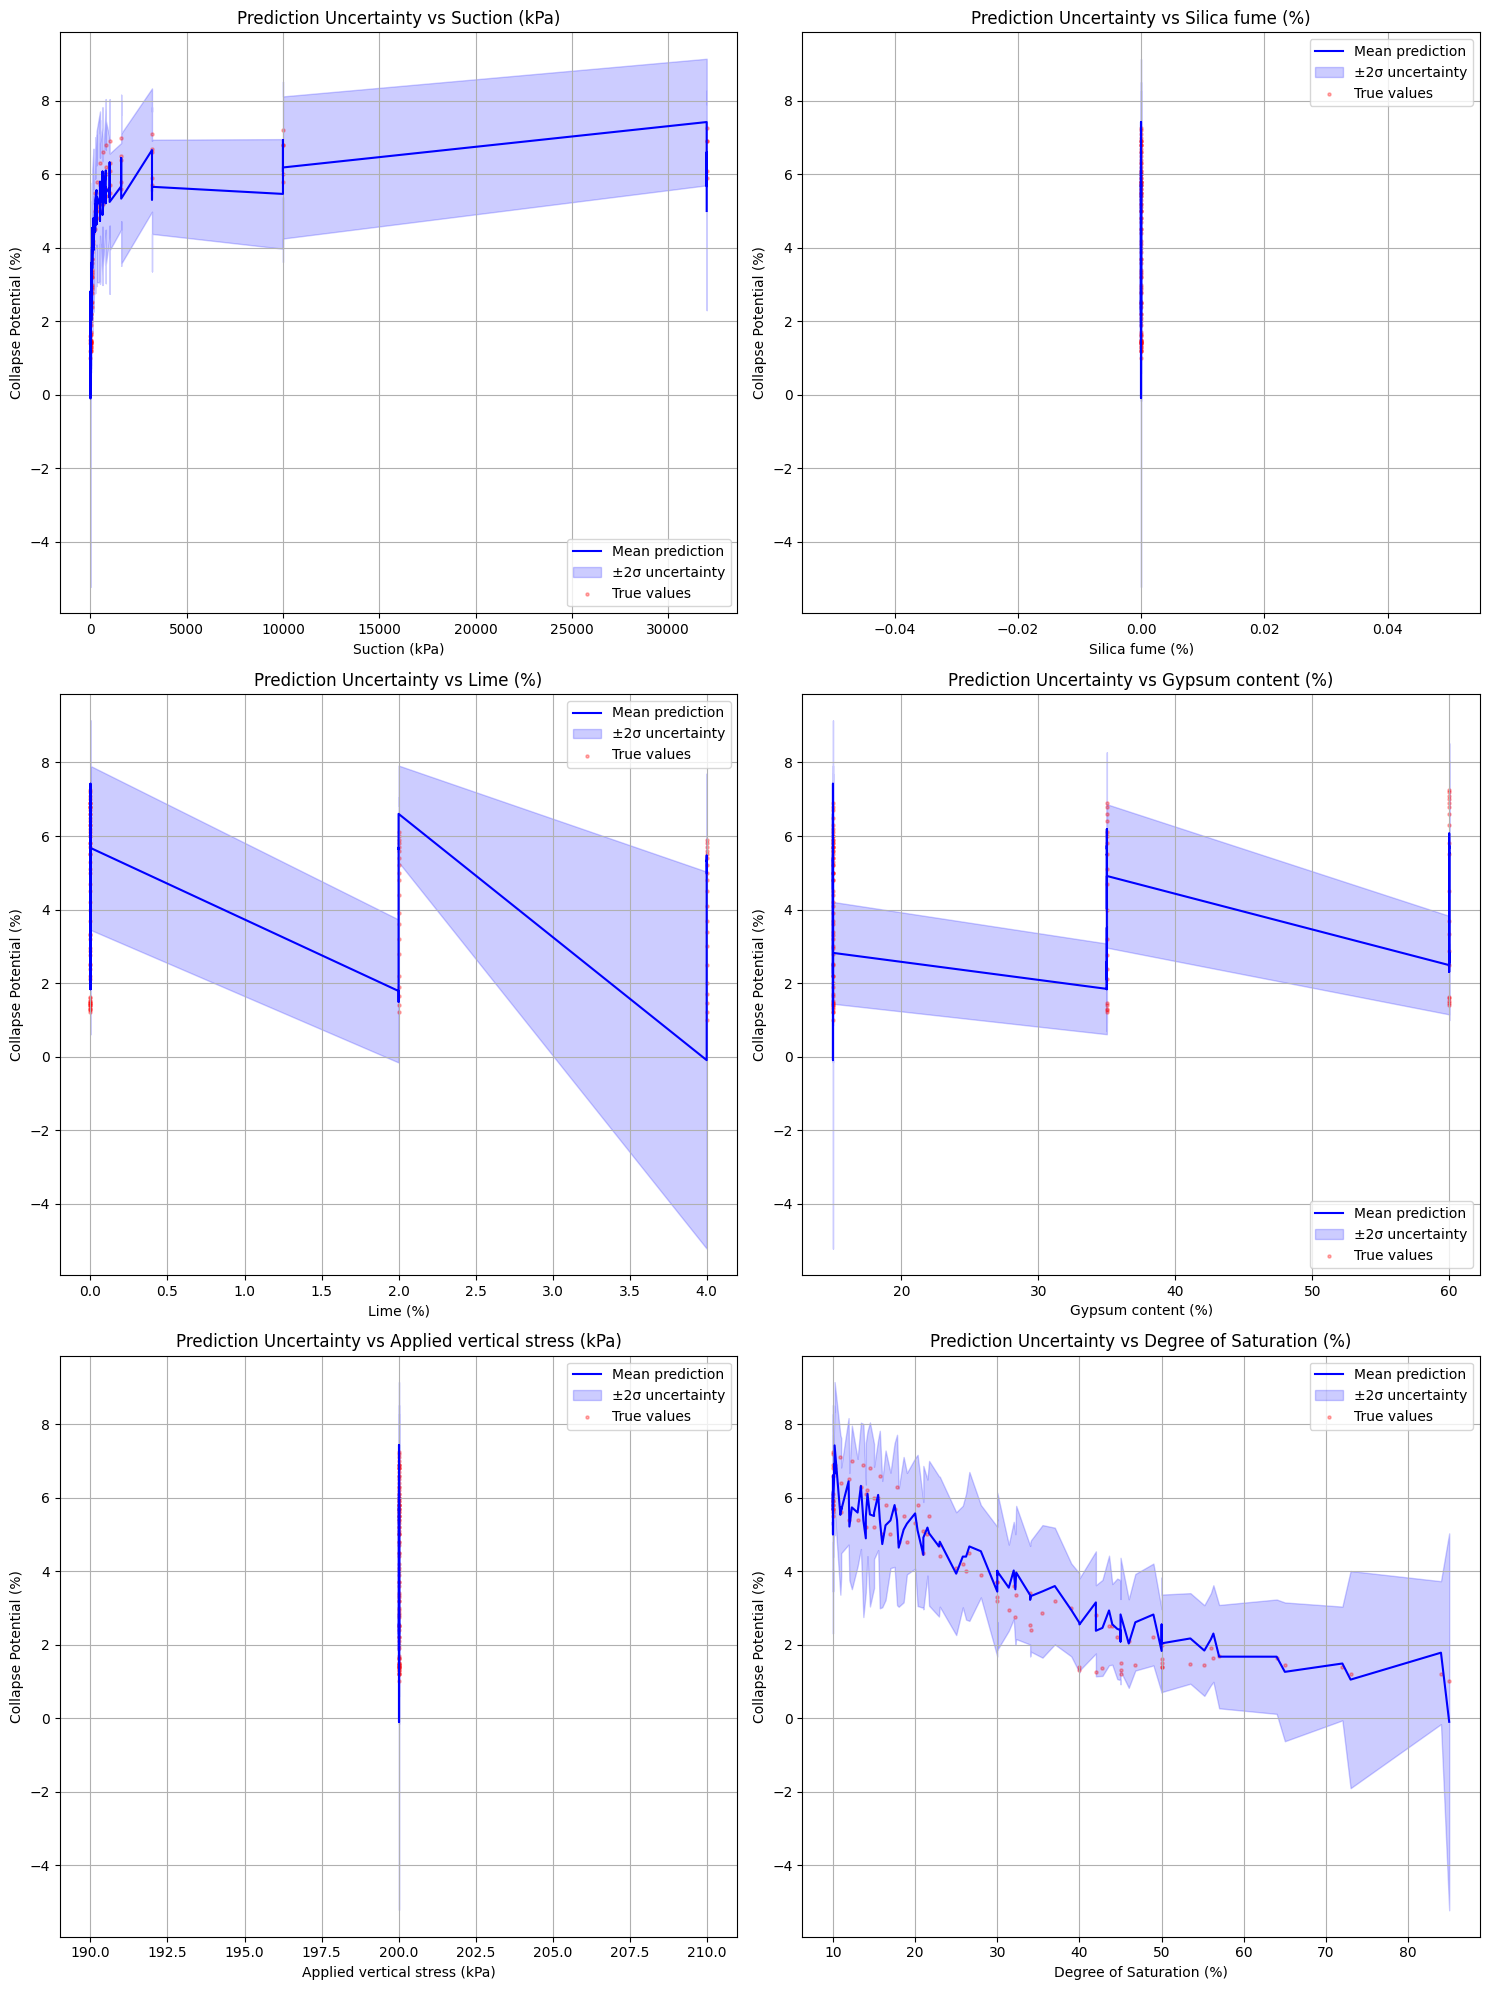

In [ ]:
# Run Uncertainty Analysis
print("\n=== Running Uncertainty Analysis ===")
mean_pred, std_pred, uncertainty_plot_path = plot_prediction_uncertainty(
    best_model, X_scaled[:100], y_scaled[:100], scaler_X, scaler_y, features, model_dir
)

In [ ]:
# Analyze parameter uncertainty
param_mean, param_std = analyze_parameter_uncertainty(best_model, X_scaled[:10])
print(f"\nParameter uncertainty impact (first 10 samples):")
print("Mean predictions:", param_mean.flatten())
print("Std deviations:", param_std.flatten())

# === Save Enhanced Model Package ===
print("\n=== Saving Enhanced Model Package ===")
performance = {'rmse': best_rmse, 'r2': all_r2}
package_dir = save_model_with_requirements(
    best_model, best_model_path, X_scaled, scaler_X, scaler_y,
    features, target, performance, model_dir
)


Parameter uncertainty impact (first 10 samples):
Mean predictions: [-0.2776206  -0.24868378 -0.26333526 -0.2708091  -0.27770787 -0.26957467
 -0.19721815 -0.16778123 -0.15066135 -0.09710948]
Std deviations: [0.0815974  0.08729676 0.08558942 0.0842547  0.08019745 0.08449378
 0.09040943 0.09136514 0.09176698 0.09251262]

=== Saving Enhanced Model Package ===

Model package saved to: /content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package


In [ ]:
def save_model_with_requirements(model, model_path, X_sample, scaler_X, scaler_y, features, target, performance, model_dir):
    """Save model with all necessary components for deployment"""
    # Create package directory
    package_dir = os.path.join(model_dir, 'deployment_package')
    os.makedirs(package_dir, exist_ok=True)

    # Save model
    model_save_path = os.path.join(package_dir, 'model.keras')
    model.save(model_save_path)

    # Save scalers
    joblib.dump(scaler_X, os.path.join(package_dir, 'scaler_X.joblib'))
    joblib.dump(scaler_y, os.path.join(package_dir, 'scaler_y.joblib'))

    # Save metadata
    metadata = {
        'features': features,
        'target': target,
        'input_dim': X_sample.shape[1],
        'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'performance': performance,
        # Save an example input
        'input_example': X_sample[0].tolist()
    }
    joblib.dump(metadata, os.path.join(package_dir, 'metadata.joblib'))

    # Generate requirements.txt
    requirements = [
        f"tensorflow=={tf.__version__}",
        f"numpy=={np.__version__}",
        f"pandas=={pd.__version__}",
        f"scikit-learn=={joblib.__version__.split('+')[0]}",
        "matplotlib",
        "joblib",
        "tk"  # For GUI
    ]

    with open(os.path.join(package_dir, 'requirements.txt'), 'w') as f:
        f.write('\n'.join(requirements))

    # Create a README with instructions
    readme = f"""# Collapse Potential Predictor Deployment Package

## Model Information
- Best RMSE: {performance['rmse']:.4f}
- Best R²: {performance['r2']:.4f}
- Features: {', '.join(features)}
- Target: {target}

## Local Deployment Instructions

1. Create a virtual environment:"""

In [ ]:
# Create Deployment Options
print("\n=== Creating Deployment Options ===")
create_gui(package_dir)
create_spreadsheet_interface(package_dir)

In [ ]:
print("\n=== Deployment Instructions ===")
print("1. GUI Application: Run the GUI that was automatically created")
print("2. Spreadsheet Integration: Use the generated spreadsheet_integration.py")
print(f"3. Full Package Location: {os.path.abspath(package_dir)}")
print(f"4. Uncertainty Analysis Plots saved to: {uncertainty_plot_path}")


=== Deployment Instructions ===
1. GUI Application: Run the GUI that was automatically created
2. Spreadsheet Integration: Use the generated spreadsheet_integration.py
3. Full Package Location: /content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package
4. Uncertainty Analysis Plots saved to: /content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/prediction_uncertainty.png


In [ ]:
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# Custom layers (must match training exactly)
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.d1 = tf.keras.layers.Dense(units, activation='tanh')
        self.d2 = tf.keras.layers.Dense(units, activation='tanh')
        self.projection = None

    def build(self, input_shape):
        if input_shape[-1] != self.units:
            self.projection = tf.keras.layers.Dense(self.units)
        super().build(input_shape)

    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        return x + (self.projection(inputs) if self.projection else inputs)

class CollapsePINN(tf.keras.Model):
    def __init__(self, input_dim=6, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = tf.keras.layers.Dense(128, activation='tanh')
        self.res_block1 = ResidualBlock(128)
        self.res_block2 = ResidualBlock(64)
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.res_block1(x)
        x = self.res_block2(x)
        return self.output_layer(x)

# Load saved artifacts
def load_artifacts(model_path, scaler_X_path, scaler_y_path):
    model = load_model(model_path, custom_objects={
        'ResidualBlock': ResidualBlock,
        'CollapsePINN': CollapsePINN
    })
    scaler_X = joblib.load(scaler_X_path)
    scaler_y = joblib.load(scaler_y_path)
    return model, scaler_X, scaler_y

# Prediction function
def predict(model, scaler_X, scaler_y, input_values):
    """Make prediction with preprocessing"""
    # Convert to numpy array
    input_array = np.array(input_values, dtype=np.float32).reshape(1, -1)

    # Scale input
    scaled_input = scaler_X.transform(input_array)

    # Predict
    scaled_pred = model.predict(scaled_input)

    # Inverse scale output
    return scaler_y.inverse_transform(scaled_pred)[0][0]

# Test with user input
if __name__ == "__main__":
    # Paths to saved files (update these)
    MODEL_PATH = "/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/model.keras"
    SCALER_X_PATH = "/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/scaler_X.joblib"
    SCALER_Y_PATH = "/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/scaler_y.joblib"

    # Load model and scalers
    model, scaler_X, scaler_y = load_artifacts(MODEL_PATH, SCALER_X_PATH, SCALER_Y_PATH)

    # Get user input
    print("Enter prediction inputs:")
    suction = float(input("Suction (kPa): "))
    silica = float(input("Silica fume (%): "))
    lime = float(input("Lime (%): "))
    gypsum = float(input("Gypsum content (%): "))
    stress = float(input("Applied vertical stress (kPa): "))
    saturation = float(input("Degree of Saturation (%): "))

    # Make prediction
    pred = predict(model, scaler_X, scaler_y,
                  [suction, silica, lime, gypsum, stress, saturation])

    print(f"\nPredicted Collapse Potential: {pred:.2f}%")

Enter prediction inputs:
Suction (kPa): 50
Silica fume (%): 0
Lime (%): 6
Gypsum content (%): 15
Applied vertical stress (kPa): 200
Degree of Saturation (%): 46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step

Predicted Collapse Potential: 1.90%


In [ ]:
!pip install -q ipywidgets matplotlib
!jupyter nbextension enable --py widgetsnbextension

# %%
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Layout, VBox, HBox, Output
import IPython.display as display

# Define custom layers (must match training)
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.d1 = tf.keras.layers.Dense(units, activation='tanh')
        self.d2 = tf.keras.layers.Dense(units, activation='tanh')
        self.projection = None

    def build(self, input_shape):
        if input_shape[-1] != self.units:
            self.projection = tf.keras.layers.Dense(self.units)
        super().build(input_shape)

    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        return x + (self.projection(inputs) if self.projection else inputs)

class CollapsePINN(tf.keras.Model):
    def __init__(self, input_dim=6, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = tf.keras.layers.Dense(128, activation='tanh')
        self.res_block1 = ResidualBlock(128)
        self.res_block2 = ResidualBlock(64)
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.res_block1(x)
        x = self.res_block2(x)
        return self.output_layer(x)

# Load model and scalers
model = load_model(
    "/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/model.keras",
    custom_objects={'ResidualBlock': ResidualBlock, 'CollapsePINN': CollapsePINN}
)
scaler_X = joblib.load("/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/scaler_X.joblib")
scaler_y = joblib.load("/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/scaler_y.joblib")

# Prediction function
def predict(suction, silica, lime, gypsum, stress, saturation):
    inputs = np.array([[suction, silica, lime, gypsum, stress, saturation]])
    scaled_input = scaler_X.transform(inputs)
    scaled_pred = model.predict(scaled_input)
    return scaler_y.inverse_transform(scaled_pred)[0][0]

# Create output area for dynamic updates
out = Output()

# Slider styles
slider_layout = Layout(width='90%', height='50px')

# Create interactive widgets
suction_slider = FloatSlider(min=0, max=100, value=50, step=1, description="Suction (kPa):", layout=slider_layout)
silica_slider = FloatSlider(min=0, max=20, value=10, step=0.5, description="Silica (%):", layout=slider_layout)
lime_slider = FloatSlider(min=0, max=10, value=2, step=0.1, description="Lime (%):", layout=slider_layout)
gypsum_slider = FloatSlider(min=0, max=30, value=15, step=0.5, description="Gypsum (%):", layout=slider_layout)
stress_slider = FloatSlider(min=50, max=500, value=200, step=10, description="Stress (kPa):", layout=slider_layout)
saturation_slider = FloatSlider(min=30, max=100, value=80, step=1, description="Saturation (%):", layout=slider_layout)

def update_plot(suction, silica, lime, gypsum, stress, saturation):
    with out:
        out.clear_output(wait=True)

        # Get prediction
        pred = predict(suction, silica, lime, gypsum, stress, saturation)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Input radar plot
        categories = ['Suction', 'Silica', 'Lime', 'Gypsum', 'Stress', 'Saturation']
        values = [suction/100, silica/20, lime/10, gypsum/30, stress/500, saturation/100]

        ax1.bar(categories, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F06292'])
        ax1.set_ylim(0, 1)
        ax1.set_title("Normalized Input Values")
        ax1.tick_params(axis='x', rotation=45)

        # Prediction display
        ax2.axis('off')
        ax2.text(0.5, 0.6, f"{pred:.2f}%",
                fontsize=40, ha='center', va='center', color='#1E88E5')
        ax2.text(0.5, 0.3, "Predicted Collapse Potential",
                fontsize=12, ha='center', va='center')

        plt.tight_layout()
        plt.show()

# Connect widgets to update function
interact(update_plot,
         suction=suction_slider,
         silica=silica_slider,
         lime=lime_slider,
         gypsum=gypsum_slider,
         stress=stress_slider,
         saturation=saturation_slider)

# Display the output area
display.display(out)

# Infrence

# new new

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# Setup
os.makedirs("partial_derivatives_plots", exist_ok=True)

In [ ]:
# Load dataset
df = pd.read_excel("/content/drive/MyDrive/PINNs/Suction_vsCP-modified_1.xlsx")
features = ['Suction (kPa)', 'Silica fume (%)', 'Lime (%)',
            'Gypsum content (%)', 'Applied vertical stress (kPa)',
            'Degree of Saturation (%)']
target = 'Collapse Potential (%)'

X = df[features].values
y = df[target].values.reshape(-1, 1)

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Subset
X_sub    = X_scaled[:]#100
X_tensor = torch.tensor(X_sub, dtype=torch.float32, requires_grad=True)

In [ ]:
# Define Residual Network
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else None

    def forward(self, x):
        identity = x if self.projection is None else self.projection(x)
        out = torch.tanh(self.fc1(x))
        out = torch.tanh(self.fc2(out))
        return out + identity

class CollapsePINN(nn.Module):
    def __init__(self, input_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.res1 = ResidualBlock(128, 128)
        self.res2 = ResidualBlock(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.res1(x)
        x = self.res2(x)
        return self.out(x)

In [ ]:
# Initialize model
model = CollapsePINN()
model.eval()

CollapsePINN(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (res1): ResidualBlock(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
  (res2): ResidualBlock(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (projection): Linear(in_features=128, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# Compute prediction and gradient
CP_pred = model(X_tensor)
CP_grad = grad(outputs=CP_pred, inputs=X_tensor,
               grad_outputs=torch.ones_like(CP_pred),
               # shape: (N, num_features)
               create_graph=True)[0]

In [ ]:
# Save plots
plot_paths = []
for i, feat_name in enumerate(features):
    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(X[:, i], CP_grad[:, i].detach().numpy(),
                          alpha=0.6, label=f"∂CP/∂{feat_name}",
                          c=CP_grad[:, i].detach().numpy(), cmap="coolwarm")
    plt.colorbar(scatter, label=f"∂CP/∂{feat_name}")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel(feat_name)
    plt.ylabel(f"∂CP/∂{feat_name}")
    plt.title(f"Partial Derivative of Collapse Potential w.r.t. {feat_name}")
    plt.grid(True)
    plt.legend()
    path = f"partial_derivatives_plots/partial_derivative_{i}_{feat_name.replace(' ', '_')}.png"
    plt.tight_layout()
    plt.savefig(path)
    plot_paths.append(path)
    plt.close()

plot_paths


['partial_derivatives_plots/partial_derivative_0_Suction_(kPa).png',
 'partial_derivatives_plots/partial_derivative_1_Silica_fume_(%).png',
 'partial_derivatives_plots/partial_derivative_2_Lime_(%).png',
 'partial_derivatives_plots/partial_derivative_3_Gypsum_content_(%).png',
 'partial_derivatives_plots/partial_derivative_4_Applied_vertical_stress_(kPa).png',
 'partial_derivatives_plots/partial_derivative_5_Degree_of_Saturation_(%).png']

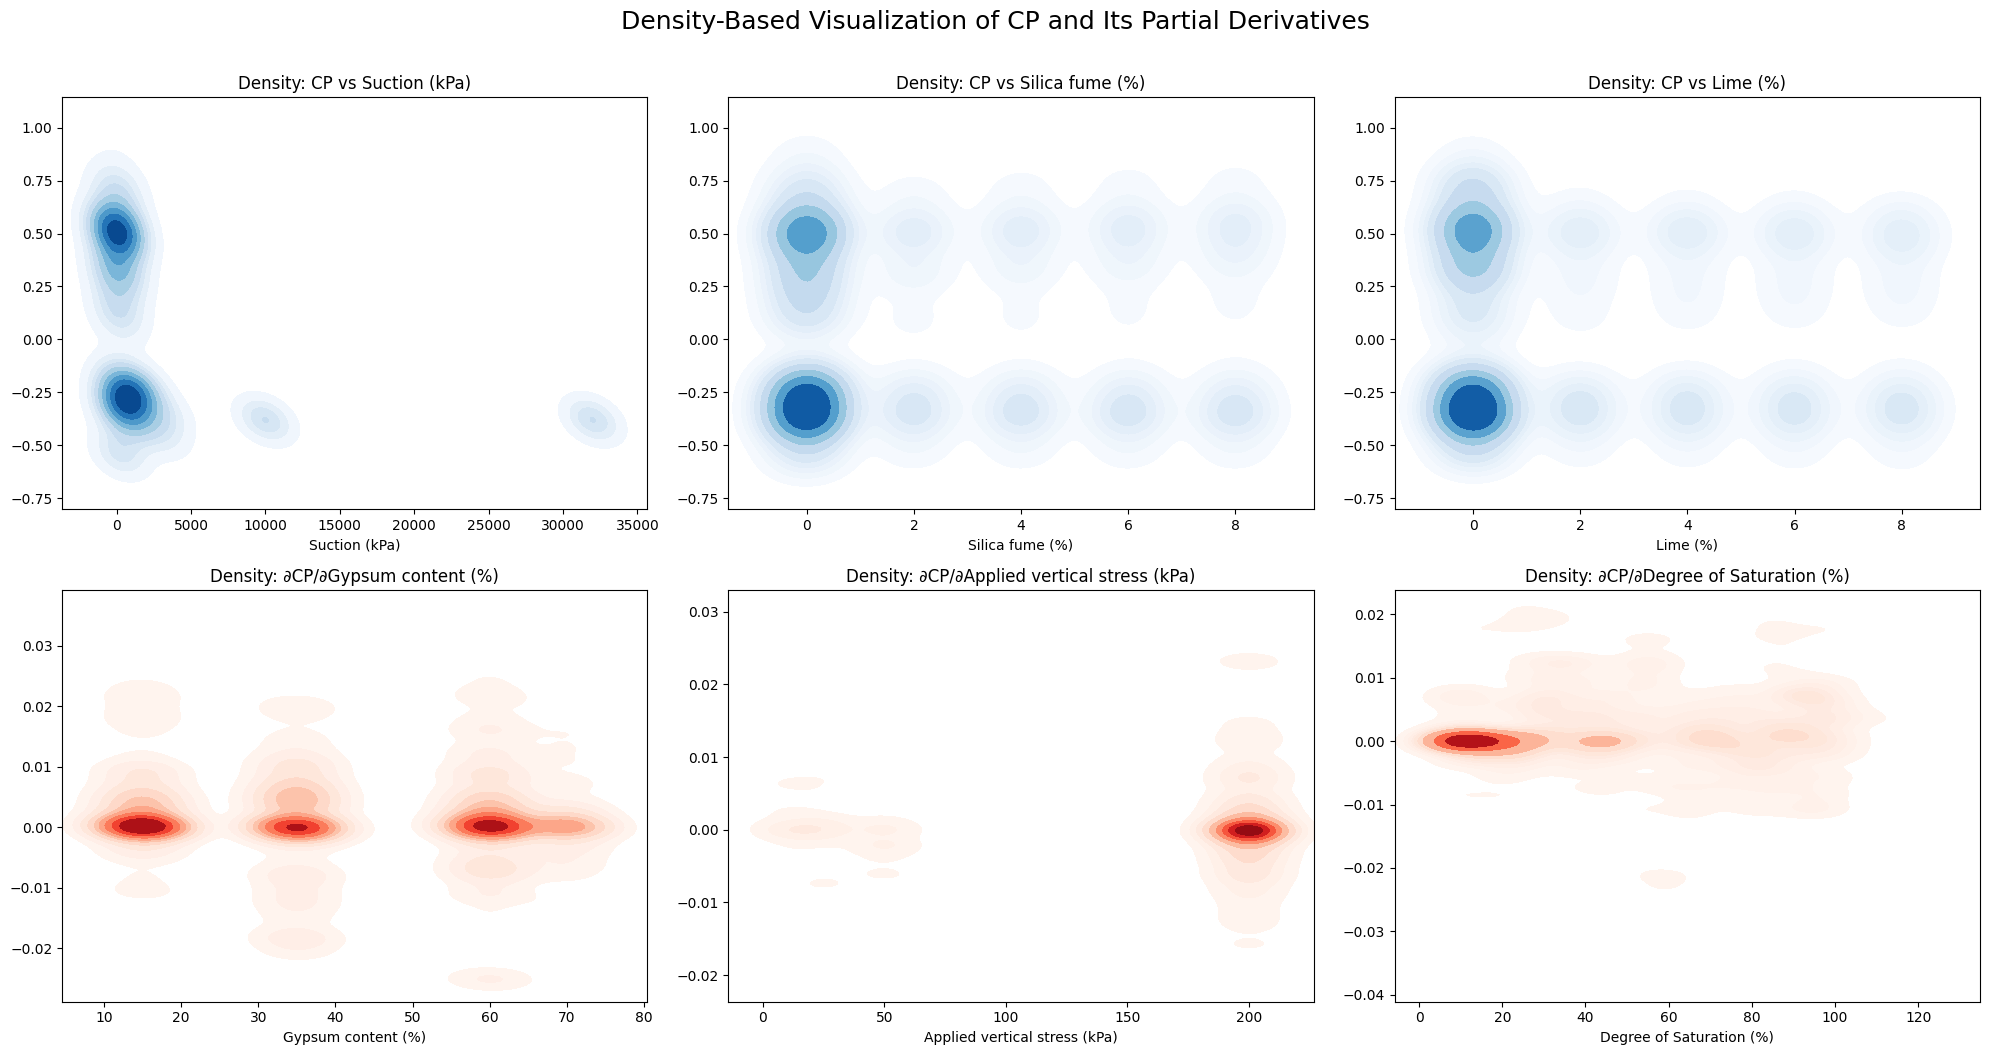

In [ ]:
import seaborn as sns

# Convert to NumPy
CP_np = CP.detach().numpy().flatten()
grads_np = grads.detach().numpy()

# Set up 2x3 grid for both CP and derivatives
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
feature_labels = ['Suction (kPa)', 'Silica fume (%)', 'Lime (%)',
                  'Gypsum content (%)', 'Applied vertical stress (kPa)',
                  'Degree of Saturation (%)']

for i, ax in enumerate(axes.flatten()):
    feature_vals = X[:, i]
    grad_vals = grads_np[:, i]

    # DataFrame for seaborn
    df_plot = pd.DataFrame({
        feature_labels[i]: feature_vals,
        'CP': CP_np,
        '∂CP/∂Feature': grad_vals
    })

    # Plot CP vs Feature (top row)
    if i < 3:
        sns.kdeplot(
            data=df_plot, x=feature_labels[i], y='CP',
            cmap="Blues", fill=True, ax=ax, bw_adjust=0.5
        )
        ax.set_title(f"Density: CP vs {feature_labels[i]}")
    # Plot ∂CP/∂Feature vs Feature (bottom row)
    else:
        sns.kdeplot(
            data=df_plot, x=feature_labels[i], y='∂CP/∂Feature',
            cmap="Reds", fill=True, ax=ax, bw_adjust=0.5
        )
        ax.set_title(f"Density: ∂CP/∂{feature_labels[i]}")

    ax.set_xlabel(feature_labels[i])
    ax.set_ylabel('')

plt.tight_layout()
plt.suptitle("Density-Based Visualization of CP and Its Partial Derivatives", fontsize=18, y=1.05)
plt.show()

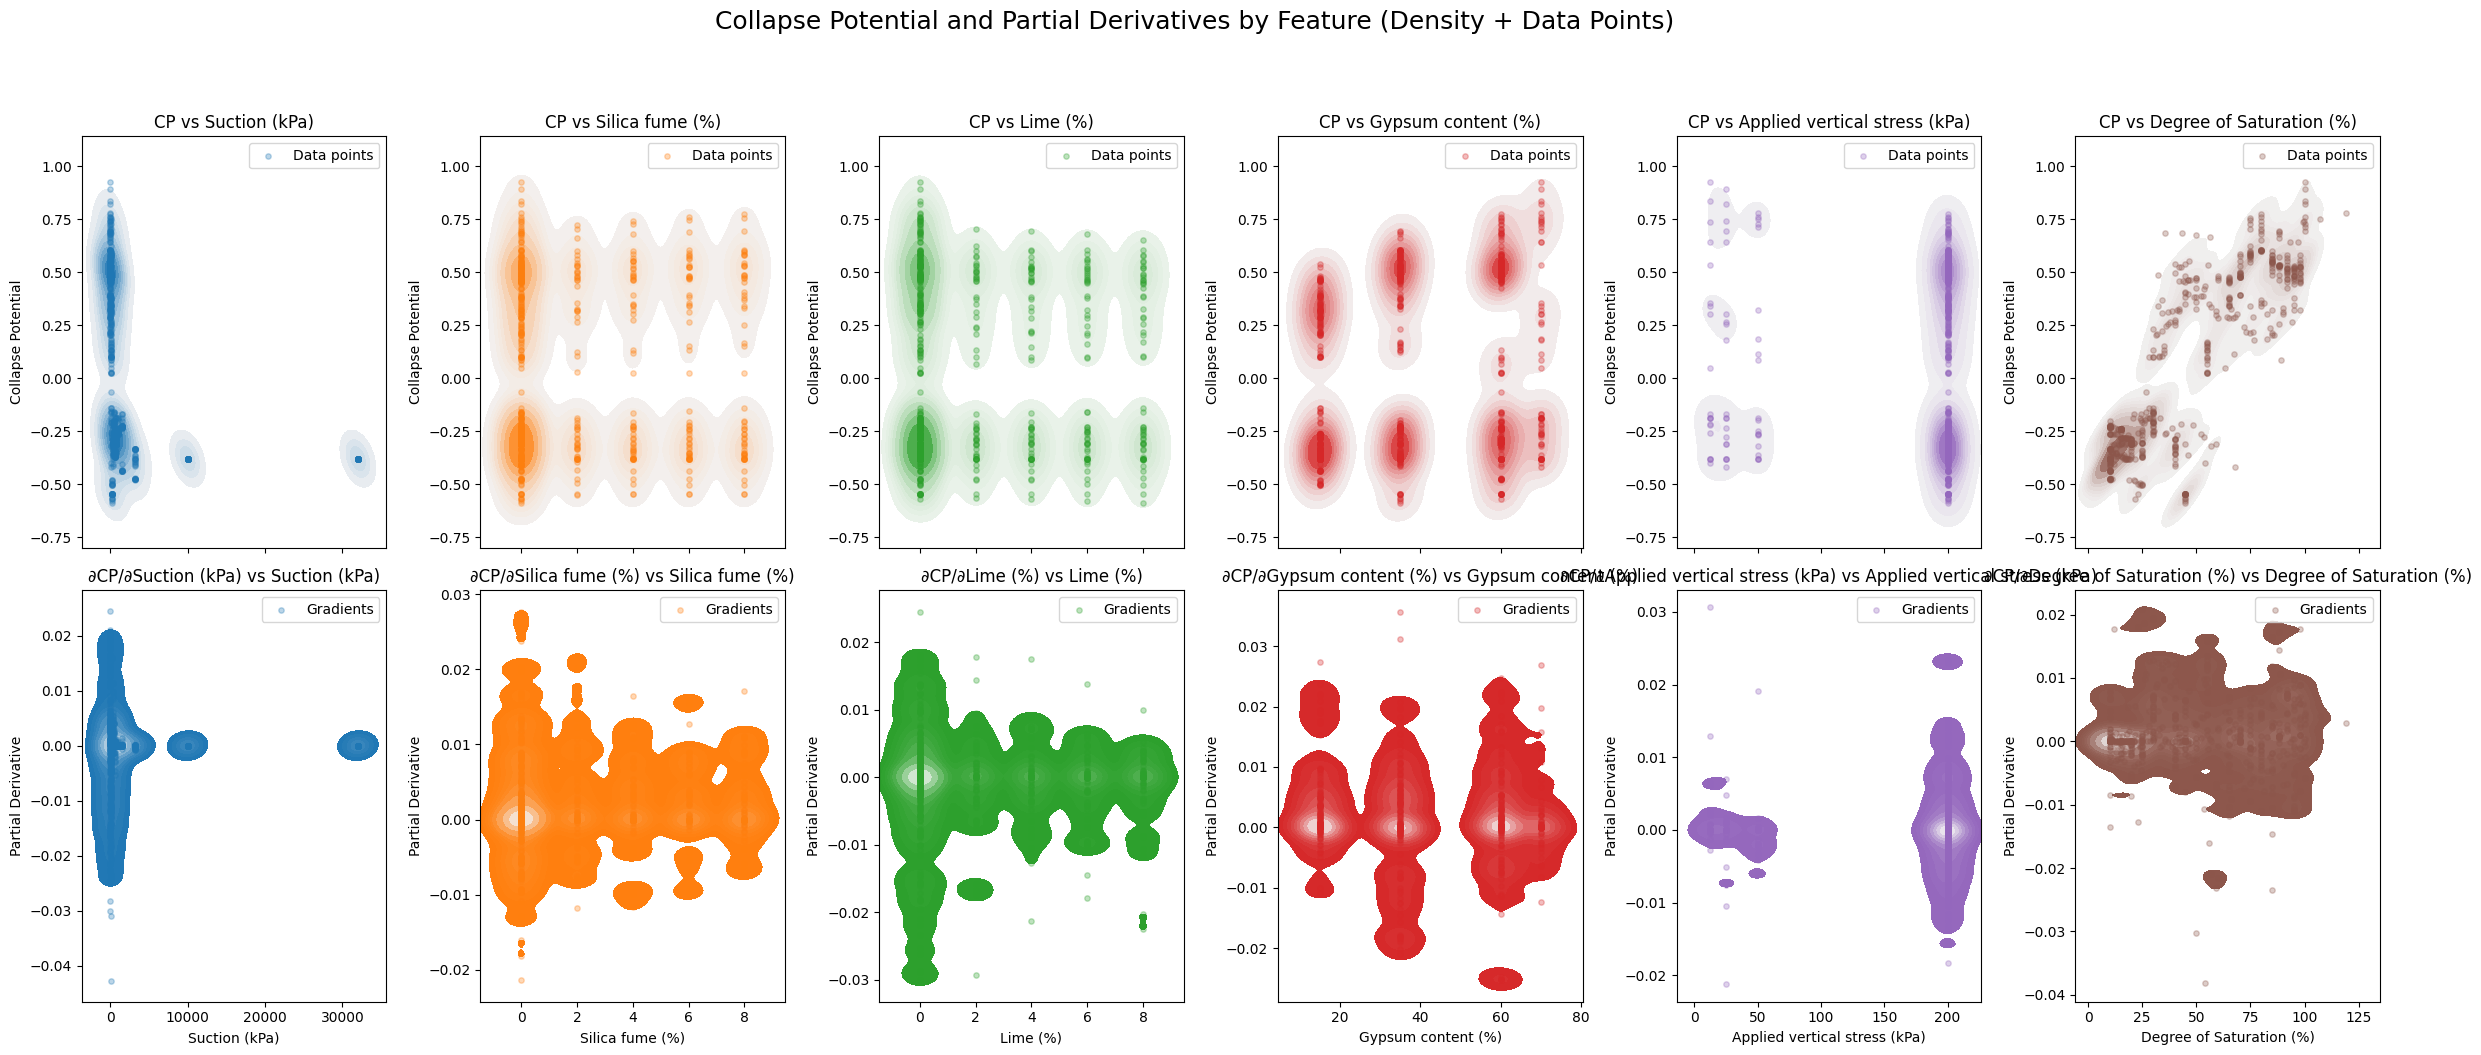

In [ ]:
import seaborn as sns

CP_np = CP.detach().numpy().flatten()
grads_np = grads.detach().numpy()

feature_labels = ['Suction (kPa)', 'Silica fume (%)', 'Lime (%)',
                  'Gypsum content (%)', 'Applied vertical stress (kPa)',
                  'Degree of Saturation (%)']

fig, axes = plt.subplots(2, 6, figsize=(24, 10), sharex='col')

# Define color palettes (one unique color per feature)
palette = sns.color_palette("tab10", n_colors=len(feature_labels))

for i, feature in enumerate(feature_labels):
    feature_vals = X[:, i]
    grad_vals = grads_np[:, i]

    # Create dataframe for seaborn
    df_plot = pd.DataFrame({
        feature: feature_vals,
        'CP': CP_np,
        '∂CP/∂Feature': grad_vals
    })

    # Top plot: CP vs Feature
    ax_top = axes[0, i]
    sns.kdeplot(
        data=df_plot, x=feature, y='CP',
        cmap=sns.light_palette(palette[i], as_cmap=True),
        fill=True, ax=ax_top, bw_adjust=0.5
    )
    # Overlay actual points for CP
    ax_top.scatter(feature_vals, CP_np, color=palette[i], alpha=0.3, s=15, label='Data points')
    ax_top.set_title(f"CP vs {feature}")
    ax_top.set_ylabel('Collapse Potential')
    ax_top.legend()

    # Bottom plot: ∂CP/∂Feature vs Feature
    ax_bot = axes[1, i]
    sns.kdeplot(
        data=df_plot, x=feature, y='∂CP/∂Feature',
        cmap=sns.light_palette(palette[i], reverse=True, as_cmap=True),
        fill=True, ax=ax_bot, bw_adjust=0.5
    )
    # Overlay actual points for derivatives
    ax_bot.scatter(feature_vals, grad_vals, color=palette[i], alpha=0.3, s=15, label='Gradients')
    ax_bot.set_title(f"∂CP/∂{feature} vs {feature}")
    ax_bot.set_xlabel(feature)
    ax_bot.set_ylabel('Partial Derivative')
    ax_bot.legend()

plt.suptitle("Collapse Potential and Partial Derivatives by Feature (Density + Data Points)", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

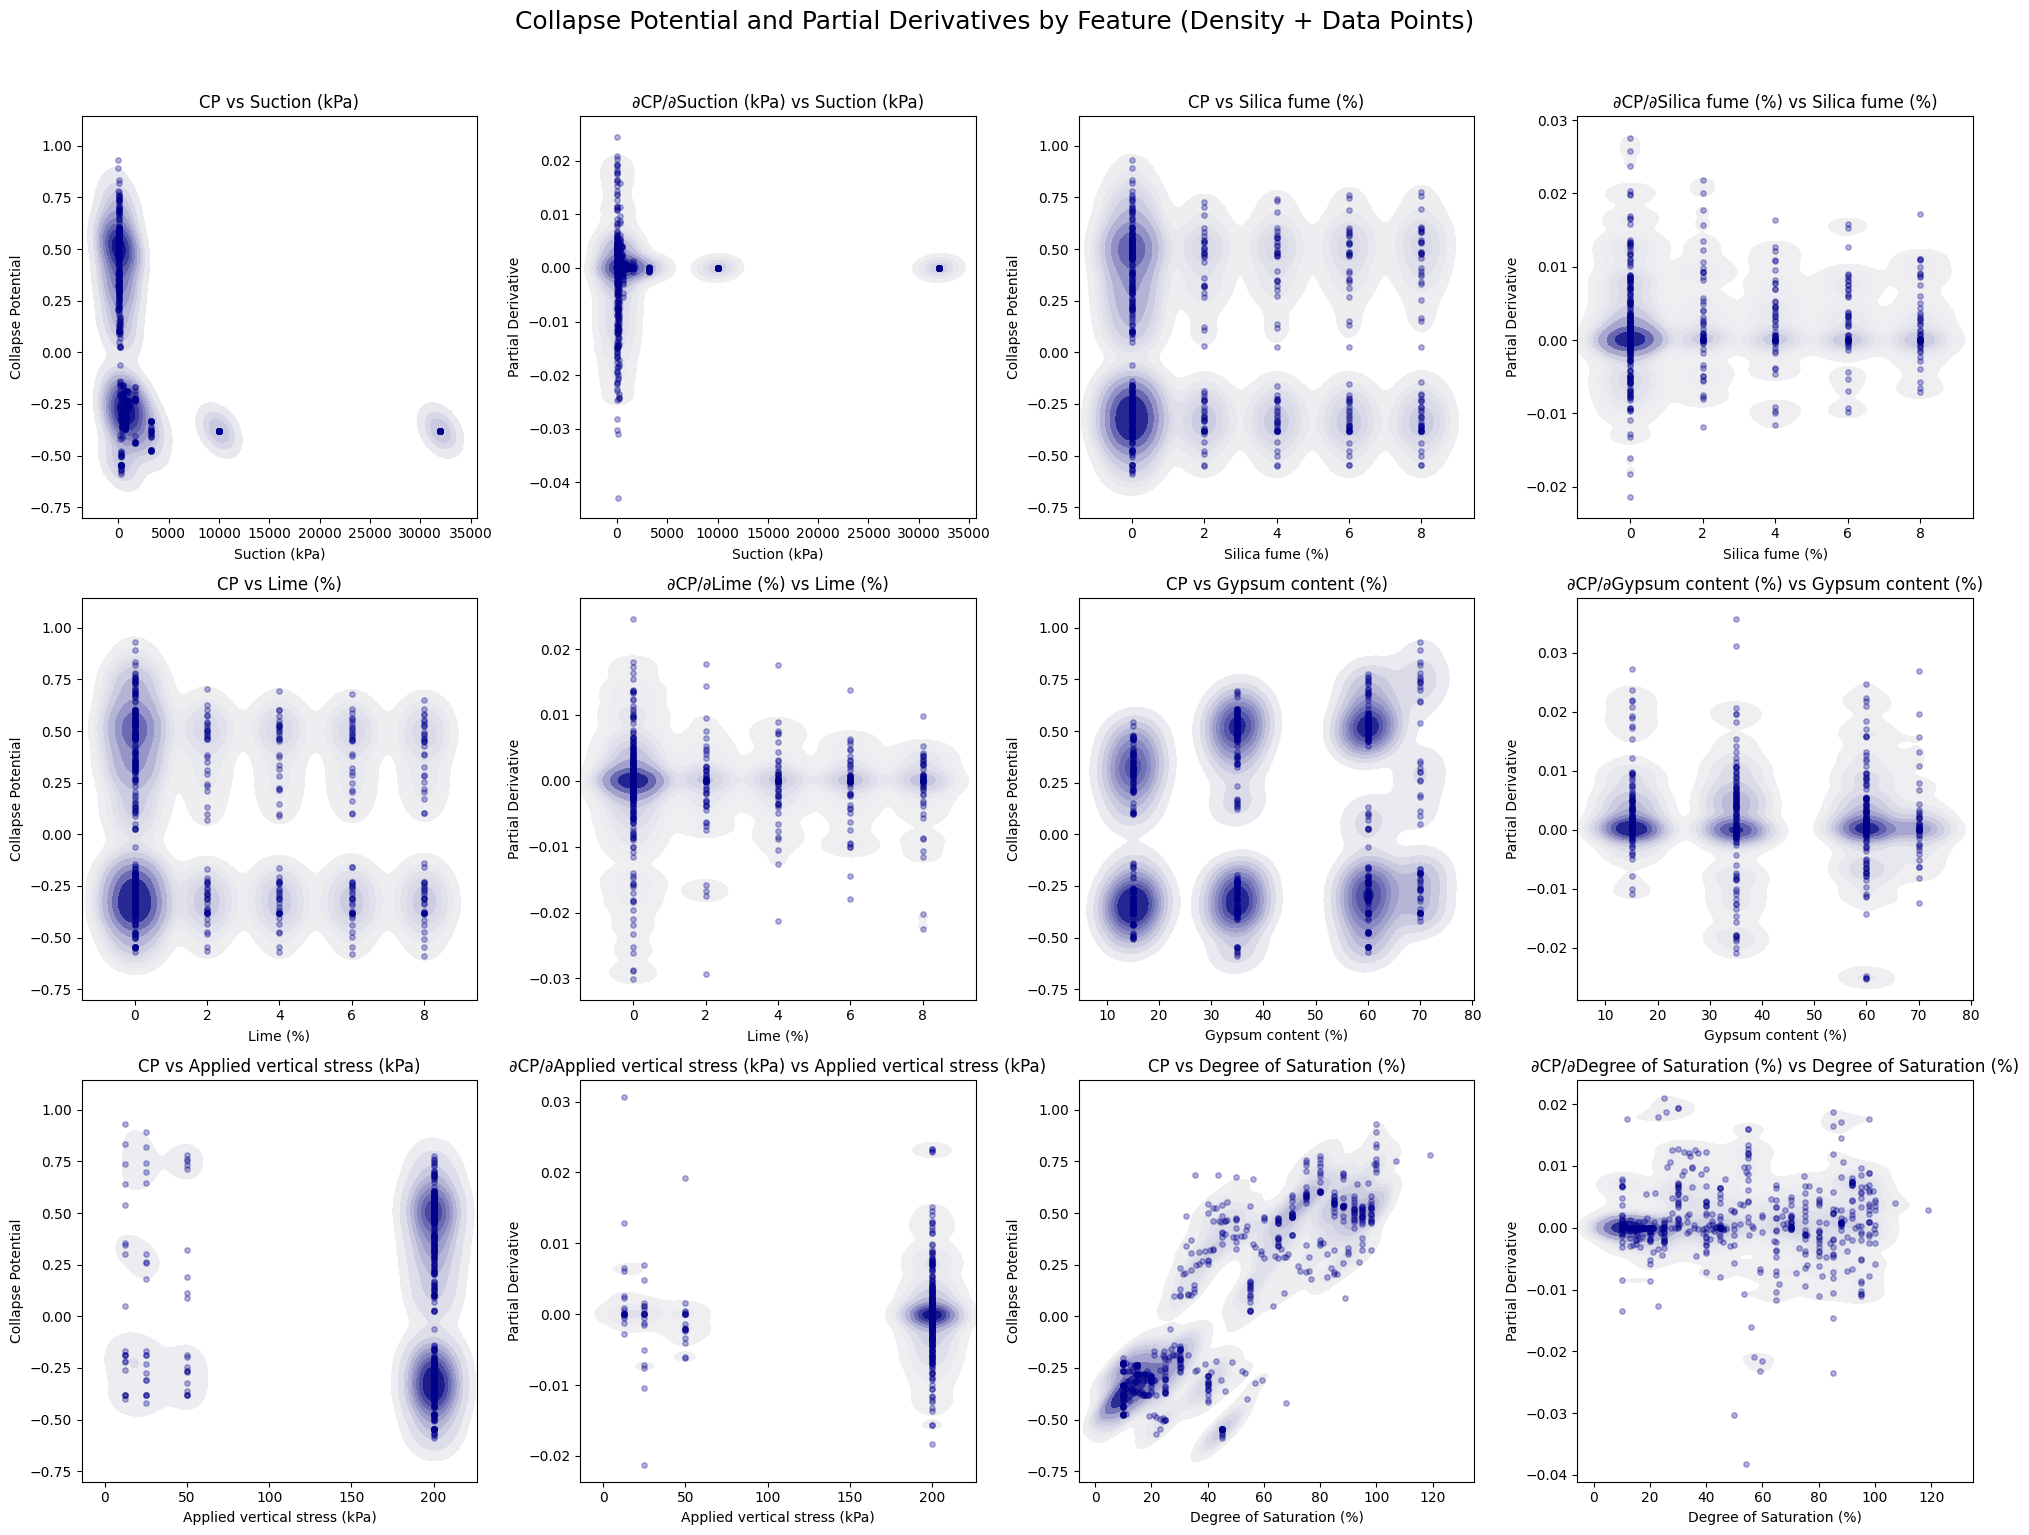

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

CP_np = CP.detach().numpy().flatten()
grads_np = grads.detach().numpy()

feature_labels = ['Suction (kPa)', 'Silica fume (%)', 'Lime (%)',
                  'Gypsum content (%)', 'Applied vertical stress (kPa)',
                  'Degree of Saturation (%)']

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
# axes shape: (3 rows, 4 cols) => for each feature we will use two vertical plots side by side in col pairs.

# Use a single blue colormap for all density plots
cmap = sns.light_palette("navy", as_cmap=True)

for i, feature in enumerate(feature_labels):
    feature_vals = X[:, i]
    grad_vals = grads_np[:, i]

    df_plot = pd.DataFrame({
        feature: feature_vals,
        'CP': CP_np,
        '∂CP/∂Feature': grad_vals
    })

    row = i // 2
    col = (i % 2) * 2  # each feature takes two cols (one for CP, one for derivative)

    # Plot CP vs feature (left subplot)
    ax_cp = axes[row, col]
    sns.kdeplot(
        data=df_plot, x=feature, y='CP',
        cmap=cmap, fill=True, ax=ax_cp, bw_adjust=0.5
    )
    ax_cp.scatter(feature_vals, CP_np, color='darkblue', alpha=0.3, s=15)
    ax_cp.set_title(f"CP vs {feature}")
    ax_cp.set_ylabel("Collapse Potential")

    # Plot partial derivative vs feature (right subplot)
    ax_grad = axes[row, col + 1]
    sns.kdeplot(
        data=df_plot, x=feature, y='∂CP/∂Feature',
        cmap=cmap, fill=True, ax=ax_grad, bw_adjust=0.5
    )
    ax_grad.scatter(feature_vals, grad_vals, color='darkblue', alpha=0.3, s=15)
    ax_grad.set_title(f"∂CP/∂{feature} vs {feature}")
    ax_grad.set_xlabel(feature)
    ax_grad.set_ylabel("Partial Derivative")

# Adjust layout tightly
plt.suptitle("Collapse Potential and Partial Derivatives by Feature (Density + Data Points)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
from torch.autograd import grad

X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)

# First: forward pass
CP = model(X_tensor)

# First derivative (gradient)
grads = grad(outputs=CP, inputs=X_tensor,
             grad_outputs=torch.ones_like(CP),
             # Retain graph for second derivative
             create_graph=True)[0]

# Second derivative: compute per-feature
second_derivs = []
for i in range(X.shape[1]):
    grad_i = grads[:, i]
    second_deriv_i = grad(grad_i, X_tensor, grad_outputs=torch.ones_like(grad_i),
                          retain_graph=True)[0][:, i]
    second_derivs.append(second_deriv_i.detach().numpy())
# Shape: (n_samples, n_features)
second_derivs_np = np.stack(second_derivs, axis=1)

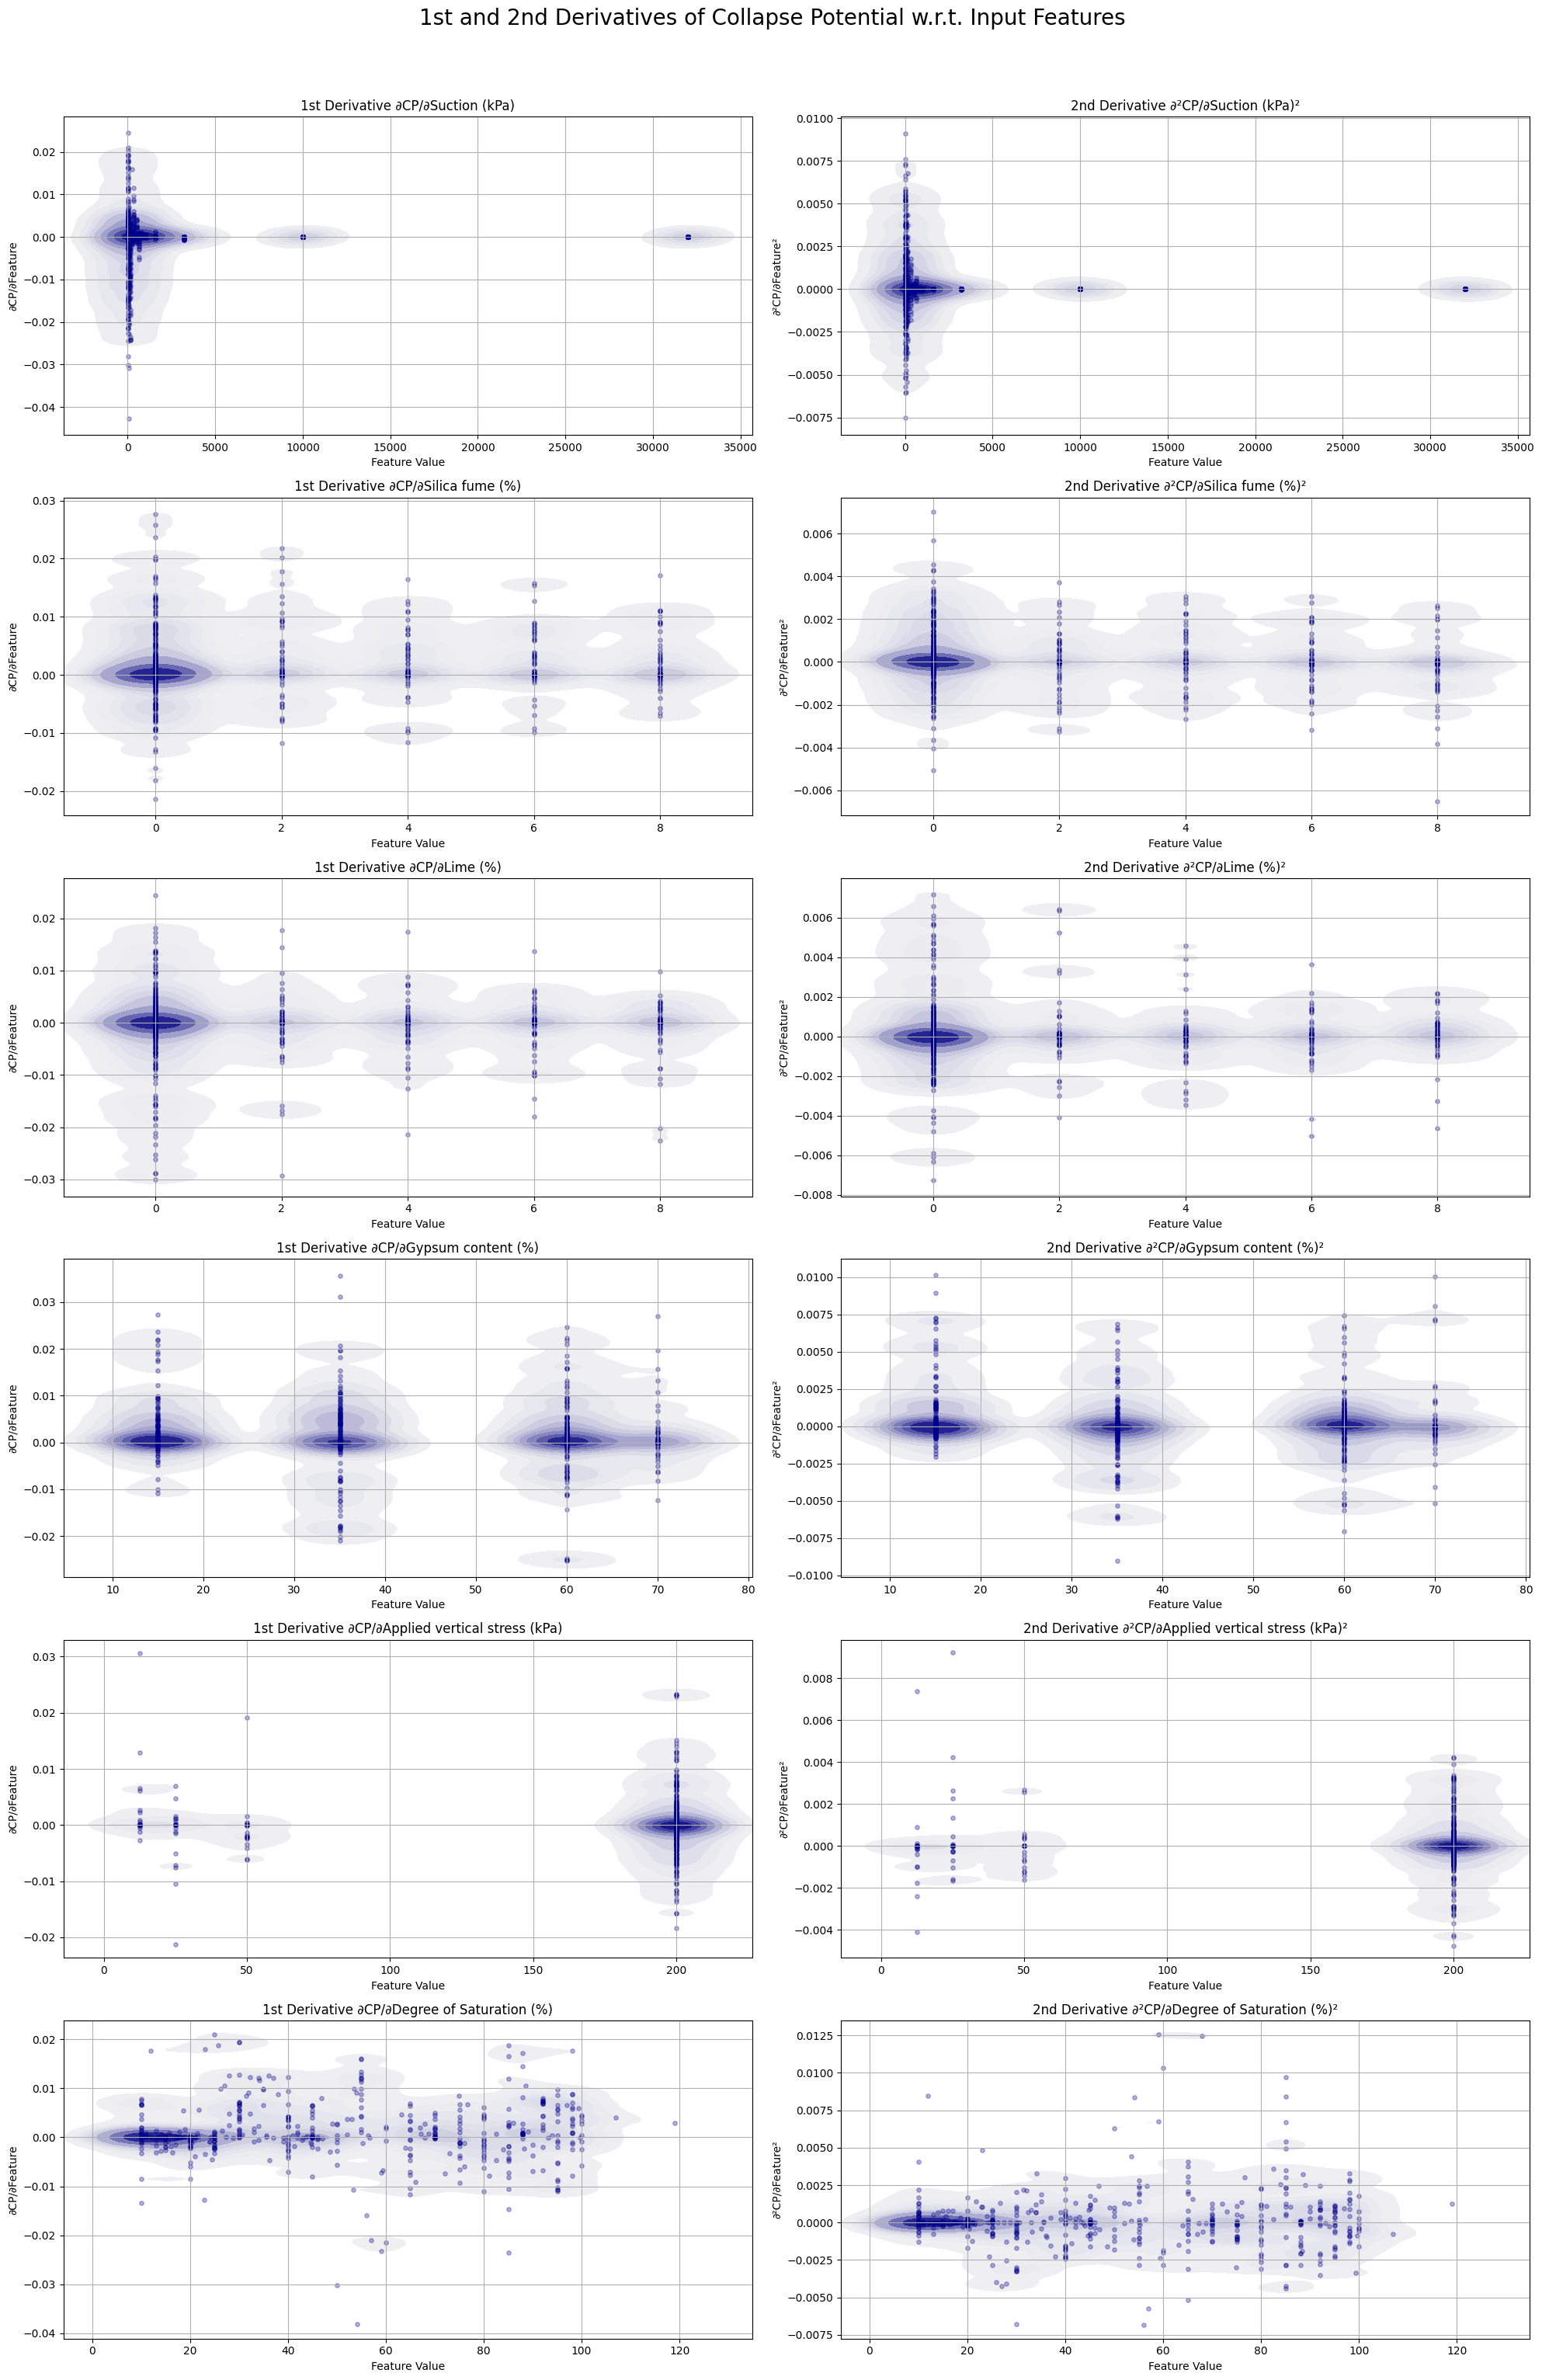

In [ ]:
# 6 rows, 2 columns: one plot per feature
fig, axes = plt.subplots(6, 2, figsize=(20, 30))

for i, feature in enumerate(feature_labels):
    feature_vals = X[:, i]
    grad_vals = grads_np[:, i]
    second_vals = second_derivs_np[:, i]

    df_plot = pd.DataFrame({
        feature: feature_vals,
        'CP': CP_np,
        '∂CP/∂Feature': grad_vals,
        '∂²CP/∂Feature²': second_vals
    })

    ax = axes[i, 0]
    sns.kdeplot(data=df_plot, x=feature, y='∂CP/∂Feature',
                cmap=cmap, fill=True, ax=ax, bw_adjust=0.5)
    ax.scatter(feature_vals, grad_vals, color='darkblue', alpha=0.3, s=15)
    ax.set_title(f"1st Derivative ∂CP/∂{feature}")
    ax.set_ylabel("∂CP/∂Feature")

    ax2 = axes[i, 1]
    sns.kdeplot(data=df_plot, x=feature, y='∂²CP/∂Feature²',
                cmap=cmap, fill=True, ax=ax2, bw_adjust=0.5)
    ax2.scatter(feature_vals, second_vals, color='darkblue', alpha=0.3, s=15)
    ax2.set_title(f"2nd Derivative ∂²CP/∂{feature}²")
    ax2.set_ylabel("∂²CP/∂Feature²")

for ax in axes.flat:
    ax.set_xlabel("Feature Value")
    ax.grid(True)

plt.suptitle("1st and 2nd Derivatives of Collapse Potential w.r.t. Input Features", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
print("\n=== Creating Spreadsheet Integration Option ===")
create_spreadsheet_interface(package_dir)


=== Creating Spreadsheet Integration Option ===
Spreadsheet integration code saved to: /content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/spreadsheet_integration.py


'/content/drive/MyDrive/PINNs/PINNs_Exp2_2_ICE_2_MC/deployment_package/spreadsheet_integration.py'